# Data Mining Final Project
## Group 9: Joana Lorenz, Joris Bertens, Luis Riveros, Shabbir Momin


The following contains the full project code for the Data Mining final project. All approaches are commented and further explained in the report. Approaches that were considered but not pursued are marked as 'TEST Approach'.

## Data Import

In [1]:
# Import relevant packages

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import sklearn 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage#, set_link_color_pallete
from scipy.cluster import hierarchy
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn import mixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes
from mpl_toolkits.mplot3d import Axes3D
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
import matplotlib.cm as cm

ModuleNotFoundError: No module named 'kmodes'

In [ ]:
# Connect to the database
my_path = 'insurance.db'
conn = sqlite3.connect(my_path)
cursor = conn.cursor()

In [ ]:
# Create tables and save in df
query_LOB= """select * from LOB"""
query_Engage = """select * from Engage"""
query_Merge = """select * from LOB join Engage using ('Customer Identity')"""

In [ ]:
# Define data frame
df_LOB= pd.read_sql_query(query_LOB,conn)
df_Engage = pd.read_sql_query(query_Engage,conn)
df_Merge= pd.read_sql_query(query_Merge,conn)

In [ ]:
# Show tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

## Data Cleaning

In [ ]:
# Fix basic data inconsistencies
df_Merge.drop(columns='index',inplace=True)
df_Merge = df_Merge.rename(columns={'Brithday Year': 'Birthday Year', 'Premiums in LOB:  Life':'Premiums in LOB: Life'})

In [ ]:
# Exploring column names
df_Merge.columns

In [ ]:
# Data size 
df_Merge.shape

In [ ]:
# Save data set size to variable for later comparison
initial_size = df_Merge.shape[0]

In [ ]:
# Data types and values information of df_Merge
df_Merge.info()

In [ ]:
# Basic stats of df_Merge
df_Merge.describe()

In [ ]:
# Value count of data information of customers
print(df_Merge['Birthday Year'].value_counts())
print(df_Merge['First Policy´s Year'].value_counts())
print(df_Merge['Educational Degree'].value_counts())
print(df_Merge['Has Children (Y=1)'].value_counts())

In [ ]:
# Value count of data information of customers
print(df_Merge['Educational Degree'].value_counts())
print(df_Merge['Has Children (Y=1)'].value_counts())

In [ ]:
#Checking the amount of data points where birthday is after first policy year

Policy_val= df_Merge["First Policy´s Year"]-df_Merge["Birthday Year"]
Policy_value_error = df_Merge[Policy_val<=0]
print('The amount of data where first policy year < birthday: ',Policy_value_error.shape[0]/df_Merge.shape[0])
# ~21 % of our data have a birthday year > first policy year, which is not possible.


In [ ]:
# Pearson correlations for the dataset (before data cleaning)
corr=df_Merge.corr(method='pearson')
corr_iloc = corr.iloc[1:,1:]
corr

In [ ]:
# Save ages in case we want to use them later on
birthday_years = pd.DataFrame(df_Merge[['Customer Identity','Birthday Year']])
birthday_years['age'] = 2016- df_Merge['Birthday Year']

In [ ]:
# We replace the values of Educational Degree to numerical values, so it will be easier to use them in an analysis
df_Merge.replace(to_replace={'2 - High School':2,'1 - Basic':1,'3 - BSc/MSc':3,'4 - PhD':4},inplace=True)

# We drop the birth year of the persons, because this data seems to be invalid. This is due to the fact that some birthyear were given as a later date of time then some of the first years of policy. 
df_Merge = df_Merge.drop(['Birthday Year'], axis=1)

In [ ]:
#We transformed First Policy's Year into the Membership duration.
df_Merge['Membership Duration'] = 2016 - df_Engage['First Policy´s Year']

# After that First Policy's Year was dropped
df_Merge.drop(columns  = ['First Policy´s Year'], inplace=True)

### Null and 0 value treatment

In [ ]:
# Count 0 values
(df_Merge==0).sum()

In [ ]:
# the 60 zero values of Premiums in LOB: Household are replaced by NaN values
df_Merge['Premiums in LOB: Household'] = df_Merge['Premiums in LOB: Household'].replace(0,np.nan)

In [ ]:
# Count null values
df_Merge.isnull().sum()

In [ ]:
# Replacing NaN values with 0's in the LOB's, because in this case there is a high probability that Nan means that these persons dont have this specific insurance so Nan=0
df_Merge[['Premiums in LOB: Motor','Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']] = df_Merge[['Premiums in LOB: Motor','Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']].fillna(value=0)

# drop null values for all columns except for LOB's.
df_Merge = df_Merge.dropna(axis=0, subset=['Membership Duration', 'Educational Degree','Geographic Living Area','Has Children (Y=1)','Customer Monetary Value','Claims Rate','Gross Monthly Salary'])

### TEST Approach: K-Nearest-Neighbors for Imputing

In [ ]:
#### KNeighbors

# KNeigbors for 'Gross Monthly Salary' based on the 'Premiums in LOB'
#my_data = df_Merge[['Gross Monthly Salary','Customer Identity','Premiums in LOB: Motor','Premiums in LOB: Household', 'Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']].apply(pd.to_numeric)

#my_data.isnull().sum()

#create a table with all the complete data
#my_data_complete = my_data.dropna()
#my_data_complete.apply(pd.to_numeric)

#create a table with all the incomplete data
#my_data_incomplete = my_data[pd.isnull(my_data).any(axis=1)]
#my_data_incomplete.isnull().sum()

#my_data_incomplete.head()

# We need the indexes of our incomplete and complete customer identities to later merge the tables back together in a propper way. Therefore two lists are created containing the indexes of the 'customer identities'.
#indexlistincomplete = my_data_incomplete['Customer Identity'].tolist()
#indexlistcomplete = my_data_complete['Customer Identity'].tolist()

# We drop the 'Customer Identity' column because it is not used to predict the 'Gross Monthly Salary' and we acquired the 'Customer Identity' in a list to be used to re-index later.
#my_data_incomplete = my_data_incomplete.drop(['Customer Identity'], axis=1)

#Create my classifier KNN Learner
#clf = KNeighborsClassifier(3, weights='uniform', metric = 'euclidean')
#trained_model = clf.fit(my_data_complete.loc[:,['Premiums in LOB: Motor','Premiums in LOB: Household', 'Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']], my_data_complete.loc[:,'Gross Monthly Salary'])

# Predict missing values' class
#imputed_values = trained_model.predict(my_data_incomplete.drop(columns = ['Gross Monthly Salary']))

#temp_df = pd.DataFrame(imputed_values.reshape(-1,1), columns = ['Gross Monthly Salary'])
#my_data_incomplete = my_data_incomplete.drop(columns=['Gross Monthly Salary'])
#my_data_incomplete = my_data_incomplete.reset_index(drop=True)

#my_data_incomplete = pd.concat([temp_df, my_data_incomplete], 
 #         axis=1, 
  #        ignore_index=True, 
   #       verify_integrity=False)

# Set columns
#my_data_incomplete.columns = ['Gross Monthly Salary','Premiums in LOB: Motor','Premiums in LOB: Household', 'Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']

# To reset the right index we are using the 'Customer Identity' to retrieve the right position of the missing values in the table. We use the created list before (indexlistincomplete) to set the right index.
#my_data_incomplete.reset_index(drop=True)
#my_data_incomplete['Customer Identity'] = indexlistincomplete
#my_data_incomplete.set_index('Customer Identity',inplace=True)

# To reset the right index we are using the 'Customer Identity' to retrieve the right position of the non-missing values in the table. We use the created list before (indexlistcomplete) to set the right index.
#my_data_complete.reset_index(drop=True)
#my_data_complete['Customer Identity'] = indexlistcomplete
#my_data_complete.set_index('Customer Identity',inplace=True)

# Now the indexes are all set right it is time to finally concatenate the incomplete and complete table. After that we resort the index so that all indexes are in an ascending order.
#my_data_full = pd.concat([my_data_complete, my_data_incomplete], axis=0, ignore_index=False,verify_integrity=False)
#my_data_full = my_data_full.sort_index()
#my_data_full.head(24)

# Final check to see whether all the non-null values are now predicted based on there nearest neighbour in the LOB's 
#my_data_full.isnull().sum()

# To get the the new total values of the Gross Monthly Salary in the df_Merge we update the df_Merge using Pandas update function.
#df_Merge['Gross Monthly Salary'].update(my_data_full['Gross Monthly Salary'])

#df_Merge.isnull().sum()

### Outlier detection

### TEST Approach: IQR or Z-Score Method for outlier removal

In [3]:
df_Merge.head()

NameError: name 'df_Merge' is not defined

In [24]:
# IQR method
# Calculating the interquartile ranges for each column
Q1 = df_Merge.quantile(0.25)
Q3 = df_Merge.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Removing all rows where a value is not within 1.5 IQR from Q1 or Q3
df_Merge_IQR = df_Merge[~((df_Merge < (Q1 - 1.5 * IQR)) |(df_Merge > (Q3 + 1.5 * IQR))).any(axis=1)]
# With this method we would remove 14 % of our data
(df_Merge_IQR.shape[0] -df_Merge.shape[0]) /df_Merge.shape[0]

# Less strict: Removing all rows where a value is not within 2 IQR from Q1 or Q3
df_Merge_IQR = df_Merge[~((df_Merge < (Q1 - 2* IQR)) |(df_Merge > (Q3 + 2 * IQR))).any(axis=1)]
# This still removes 9 % of our data
print('Removing outliers using the IQR method with 1.5 quartiles would lead to a change of data size: ',(df_Merge_IQR.shape[0] -df_Merge.shape[0]) /df_Merge.shape[0])

Customer Identity                      5148.5000
Premiums in LOB: Motor                  217.2600
Premiums in LOB: Household              243.4000
Premiums in LOB: Health                 108.0200
Premiums in LOB: Life                    47.1200
Premiums in LOB: Work Compensations      46.0100
Educational Degree                        1.0000
Gross Monthly Salary                   1585.7500
Geographic Living Area                    3.0000
Has Children (Y=1)                        1.0000
Customer Monetary Value                 409.1625
Claims Rate                               0.5900
Membership Duration                      12.0000
dtype: float64
Removing outliers using the IQR method with 1.5 quartiles would lead to a change of data size:  -0.09757291055000979


In [25]:
# ZSCORE Method
# For every column the z score is calculated and added as a new column
df_Merge_ZSCORE = df_Merge.copy()

cols = list(df_Merge_ZSCORE.columns)
cols.remove("Customer Identity")
df_Merge_ZSCORE[cols]

for col in cols:
    col_zscore = col + "_zscore"

    df_Merge_ZSCORE[col_zscore] = (df_Merge_ZSCORE[col] - df_Merge_ZSCORE[col].mean())/df_Merge_ZSCORE[col].std(ddof=0)

In [26]:
# Remove the outliers and get the clean data. This is done by only selecting the rows that have a lower absolute z score than 3.
for i in ['Premiums in LOB: Motor_zscore','Premiums in LOB: Household_zscore',"Premiums in LOB: Health_zscore","Premiums in LOB: Life_zscore","Premiums in LOB: Work Compensations_zscore","Educational Degree_zscore","Gross Monthly Salary_zscore","Geographic Living Area_zscore","Has Children (Y=1)_zscore","Customer Monetary Value_zscore","Claims Rate_zscore","Membership Duration_zscore"]:
    df_Merge_ZSCORE = df_Merge_ZSCORE[(df_Merge_ZSCORE[i] < 3) & (df_Merge_ZSCORE[i] > -3)] 

    # This still removes 4.3 % of our data
print('Removing outliers using the ZSCORES method with a threshold of 3 would lead to a change of data size: ',(df_Merge_ZSCORE.shape[0] -df_Merge.shape[0]) /df_Merge.shape[0])
    

Removing outliers using the ZSCORES method with a threshold of 3 would lead to a change of data size:  -0.04374633000587199


In [27]:
df_Merge.head()

,Customer Identity,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Membership Duration
0,1,375.85,79.45,146.36,47.01,16.89,2.0,2177.0,1.0,1.0,380.97,0.39,31.0
1,2,77.46,416.20,116.69,194.48,106.13,2.0,677.0,4.0,1.0,-131.13,1.12,35.0
2,3,206.15,224.50,124.58,86.35,99.02,1.0,2277.0,3.0,0.0,504.67,0.28,25.0
3,4,182.48,43.35,311.17,35.34,28.34,3.0,1099.0,4.0,1.0,-16.99,0.99,26.0
4,5,338.62,47.80,182.59,18.78,41.45,3.0,1763.0,4.0,1.0,35.23,0.90,30.0


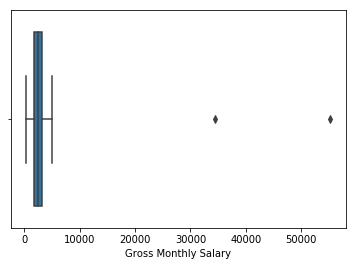

Two outliers were detected and removed


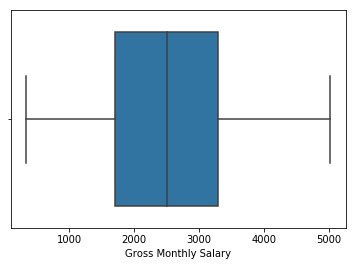

In [28]:
# Gross Monthly Salary
sns.boxplot(x=df_Merge['Gross Monthly Salary'])
plt.show()
plt.clf()

# Clean outliers:
print('Two outliers were detected and removed')
df_Merge_clean= df_Merge.loc[df_Merge['Gross Monthly Salary'] < 30000]

sns.boxplot(x=df_Merge_clean['Gross Monthly Salary'])
plt.show()

No outliers were detected


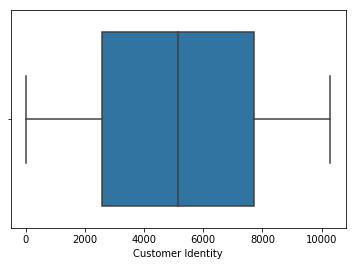

In [29]:
# Customer Identity
sns.boxplot(x=df_Merge['Customer Identity'])
print('No outliers were detected')

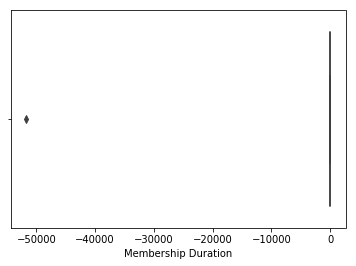

One outlier was detected and removed


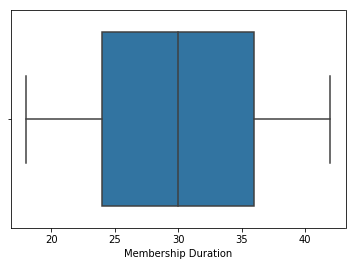

In [30]:
# First Policy's Year
sns.boxplot(x=df_Merge['Membership Duration'])
plt.show()
plt.clf()

# Clean obvious outliers:
print('One outlier was detected and removed')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Membership Duration'] >0]

sns.boxplot(x=df_Merge_clean['Membership Duration'])
plt.show()


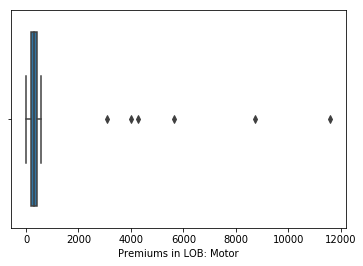

Several outliers were detected and removed


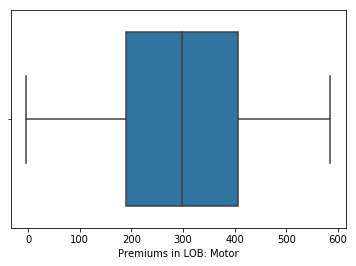

In [31]:
# Premiums in LOB: Motor
sns.boxplot(x=df_Merge['Premiums in LOB: Motor'])
plt.show()
plt.clf()

# Remove outliers from Motor
print('Several outliers were detected and removed')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Premiums in LOB: Motor'] <3000]

sns.boxplot(x=df_Merge_clean['Premiums in LOB: Motor'])

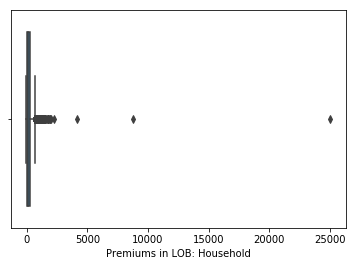

Several outliers were detected


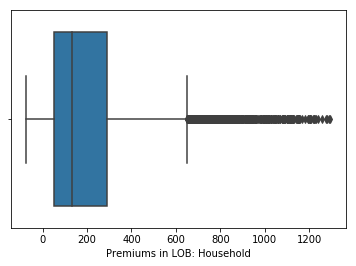

In [32]:
# Premiums in LOB: Household
sns.boxplot(x=df_Merge['Premiums in LOB: Household'])
plt.show()
plt.clf()

# Remove outliers from Household
print('Several outliers were detected')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Premiums in LOB: Household'] < 1300]

sns.boxplot(x=df_Merge_clean['Premiums in LOB: Household'])

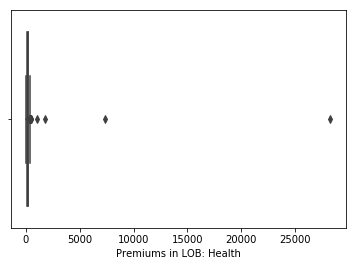

Several outliers were detected


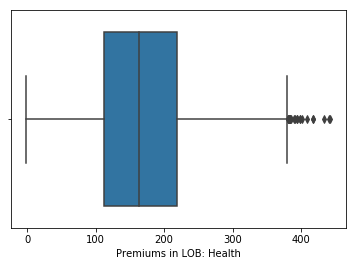

In [33]:
# Premiums in LOB: Health
sns.boxplot(x=df_Merge['Premiums in LOB: Health'])
plt.show()
plt.clf()

# Remove outliers from Health
print('Several outliers were detected')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Premiums in LOB: Health'] <750]

sns.boxplot(x=df_Merge_clean['Premiums in LOB: Health'])
plt.show()

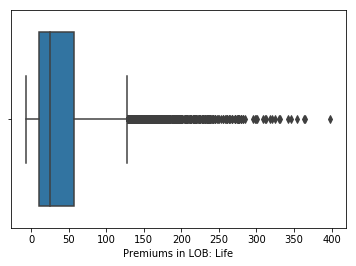

Extreme values were reduced


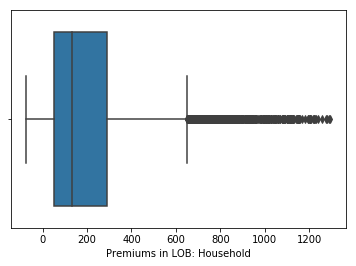

In [34]:
# Premiums in LOB: Life
sns.boxplot(x=df_Merge['Premiums in LOB: Life'])
plt.show()
plt.clf()

# Remove outliers from Life
print('Extreme values were reduced')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Premiums in LOB: Life'] <380]

sns.boxplot(x=df_Merge_clean['Premiums in LOB: Household'])

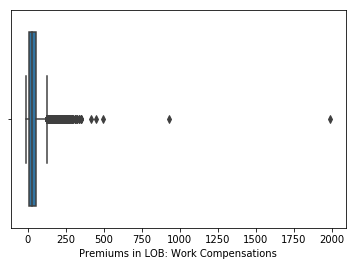

Outliers were removed, extreme values were kept


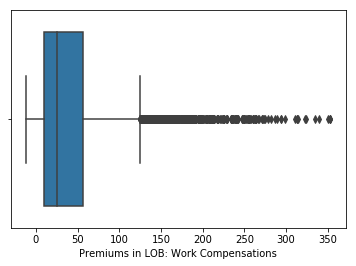

In [35]:
# Premiums in LOB: Work Compensations
sns.boxplot(x=df_Merge['Premiums in LOB: Work Compensations'])
plt.show()
plt.clf()

# Remove outliers from Work Compensations
print('Outliers were removed, extreme values were kept')
df_Merge_clean= df_Merge_clean.loc[df_Merge_clean['Premiums in LOB: Work Compensations'] <400]

sns.boxplot(x=df_Merge_clean['Premiums in LOB: Work Compensations'])
plt.show()

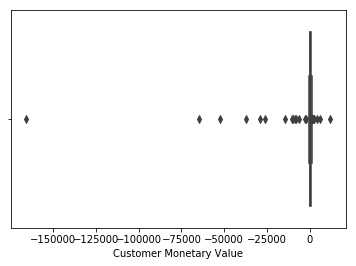

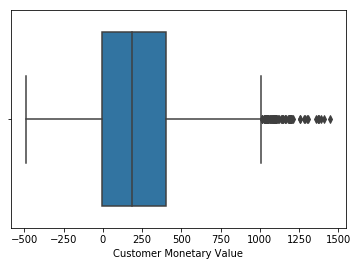

In [36]:
# Customer Monetary Value
sns.boxplot(x=df_Merge['Customer Monetary Value'])
plt.show()
plt.clf()

# Remove outliers from Customer Monetary Value
('Several outliers were detected')
df_Merge_clean = df_Merge_clean.loc[(df_Merge_clean['Customer Monetary Value'] > - 1000) & (df_Merge_clean['Customer Monetary Value'] < 4000)]

sns.boxplot(x=df_Merge_clean['Customer Monetary Value'])
plt.show()

No outliers were detected


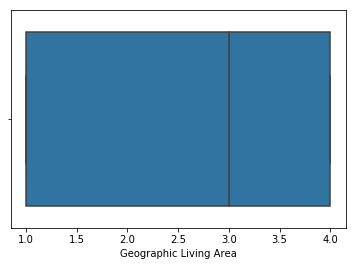

In [37]:
# Geographic Living Area
sns.boxplot(x=df_Merge_clean['Geographic Living Area'])
print('No outliers were detected')


No outliers detected


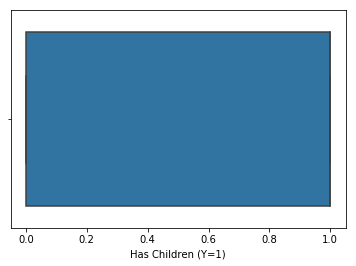

In [38]:
# Has Children (Y=1)
print('No outliers detected')
sns.boxplot(x=df_Merge_clean['Has Children (Y=1)'])

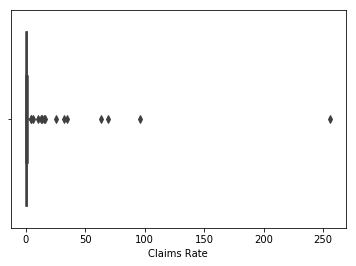

Several outliers were detected and removed


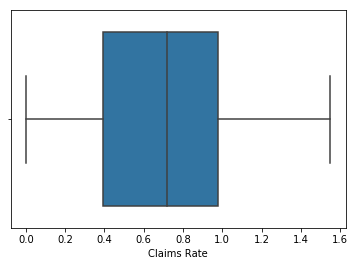

In [39]:
# Claims Rate
sns.boxplot(x=df_Merge['Claims Rate'])
plt.show()
plt.clf()

# Clean outliers
print('Several outliers were detected and removed')
df_Merge_clean = df_Merge_clean.loc[(df_Merge_clean['Claims Rate'] < 2)]
sns.boxplot(x=df_Merge_clean['Claims Rate'])
plt.show()

Final value distributions


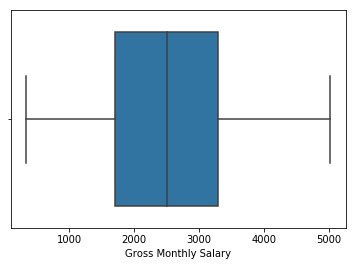

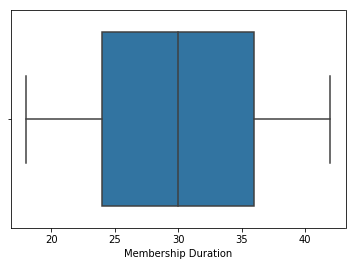

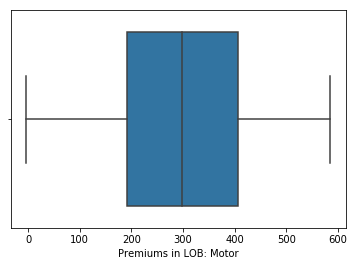

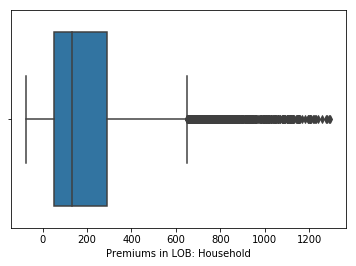

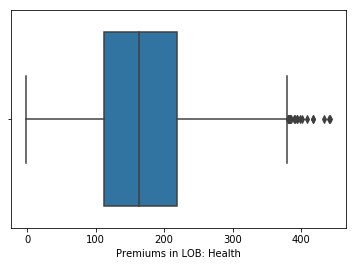

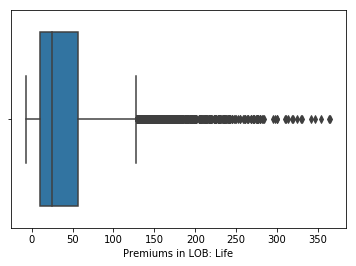

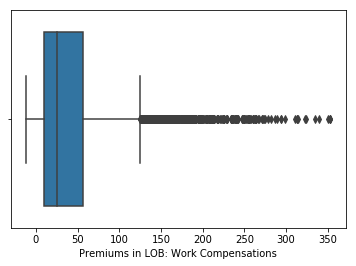

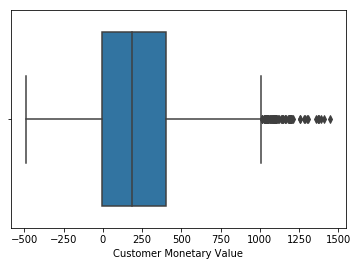

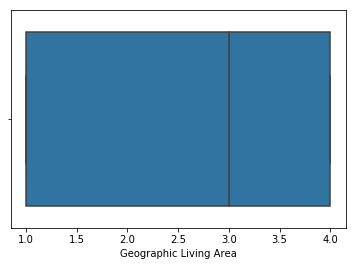

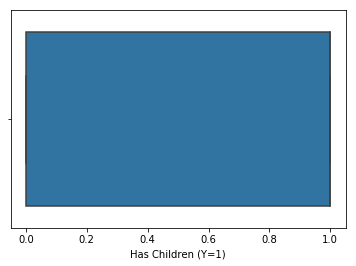

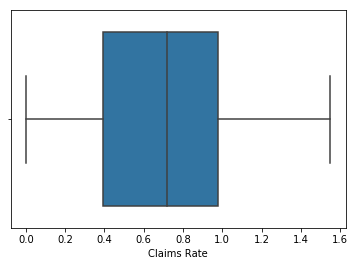

In [40]:
# Print the final distributions for each variable
print('Final value distributions')
for i in ['Gross Monthly Salary','Membership Duration','Premiums in LOB: Motor','Premiums in LOB: Household','Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations','Customer Monetary Value','Geographic Living Area','Has Children (Y=1)','Claims Rate']:
    sns.boxplot(x=df_Merge_clean[i])
    plt.show()
    plt.clf()

In [41]:
# Create an additional variable: Total premiums, indicating the total amount of LOB Premiums per customer. This might be an additional criterium for clustering
df_Merge_clean['Total Premiums'] = df_Merge_clean[['Customer Identity','Premiums in LOB: Motor','Premiums in LOB: Household','Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']].sum(axis=1)

In [42]:
# Data loss through data cleaning
data_loss = (df_Merge_clean.shape[0]-initial_size)/initial_size
print('Reduction of rows in the data set through data cleaning: ',np.round(data_loss,3))

Reduction of rows in the data set through data cleaning:  -0.017


## Data Frame Separation 

In [43]:
# Retrieve the clean data (unnormalized)
df = df_Merge_clean
df_Merge_clean.head()

# Split the LOB data into a dataframe
df_LOB = df_Merge_clean[['Customer Identity','Premiums in LOB: Motor','Premiums in LOB: Household','Premiums in LOB: Health','Premiums in LOB: Life','Premiums in LOB: Work Compensations']]

# Split the demographic & customer information data into a dataframe
df_Engage = df_Merge_clean[['Customer Identity','Membership Duration','Educational Degree','Gross Monthly Salary','Geographic Living Area','Has Children (Y=1)','Customer Monetary Value','Claims Rate','Total Premiums']]

## Data Exploration

In [44]:
# Basic statistic summary
df.describe()

,Customer Identity,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Membership Duration,Total Premiums
count,10116.00000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000,10116.000000
mean,5153.24486,296.856574,204.321278,167.818420,41.417867,40.598923,2.482009,2501.591044,2.711744,0.706999,217.320080,0.681087,29.967280,5904.257922
std,2970.55221,137.873398,225.189787,74.457046,47.304726,46.375650,0.793680,982.922106,1.267388,0.455161,253.663935,0.317349,6.601039,2979.434272
min,1.00000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000,1.000000,333.000000,1.000000,0.000000,-490.200000,0.000000,18.000000,550.000000
25%,2580.75000,191.260000,50.000000,111.800000,9.890000,10.000000,2.000000,1711.000000,1.000000,0.000000,-8.330000,0.390000,24.000000,3325.337500
50%,5154.50000,298.500000,133.350000,162.920000,25.450000,25.560000,3.000000,2503.000000,3.000000,1.000000,187.665000,0.720000,30.000000,5898.680000
75%,7722.25000,407.410000,289.500000,219.040000,57.010000,56.010000,3.000000,3293.000000,4.000000,1.000000,398.862500,0.980000,36.000000,8473.902500
max,10296.00000,585.220000,1294.700000,442.860000,365.180000,353.180000,4.000000,5021.000000,4.000000,1.000000,1448.280000,1.550000,42.000000,11723.600000


#### Correlations

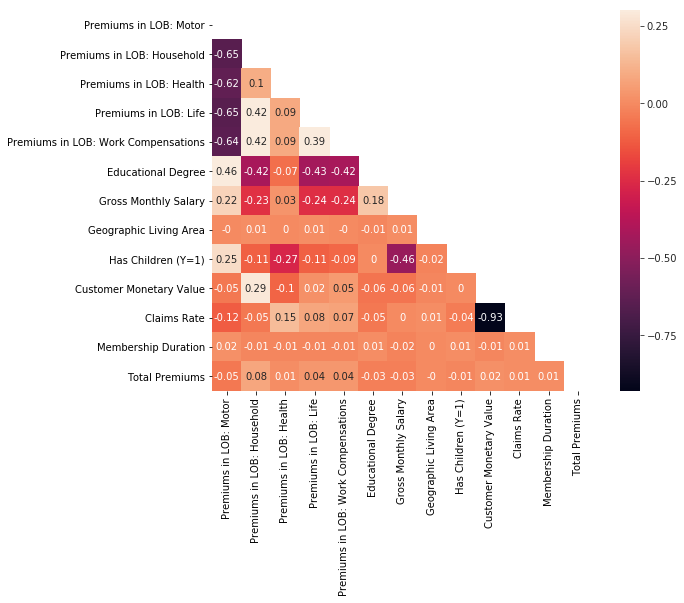

In [45]:
# Graph correlations
corr=df.corr(method='pearson').round(2)
corr_iloc = corr.iloc[1:,1:]

mask = np.zeros_like(corr_iloc)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,7))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_iloc, annot=True,mask=mask, vmax=.3, square=True)

In [46]:
# Select all pairs with absolute correlation > 0,3
attrs = corr_iloc
print(attrs)
threshold = 0.3
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()
print(important_corrs)

# Unique important correlations
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])

                                     Premiums in LOB: Motor  \
Premiums in LOB: Motor                                 1.00   
Premiums in LOB: Household                            -0.65   
Premiums in LOB: Health                               -0.62   
Premiums in LOB: Life                                 -0.65   
Premiums in LOB: Work Compensations                   -0.64   
Educational Degree                                     0.46   
Gross Monthly Salary                                   0.22   
Geographic Living Area                                -0.00   
Has Children (Y=1)                                     0.25   
Customer Monetary Value                               -0.05   
Claims Rate                                           -0.12   
Membership Duration                                    0.02   
Total Premiums                                        -0.05   

                                     Premiums in LOB: Household  \
Premiums in LOB: Motor                            

In [47]:
# Show important correlations sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
print(unique_important_corrs)

                                       attribute pair  correlation
0              (Claims Rate, Customer Monetary Value)        -0.93
5     (Premiums in LOB: Life, Premiums in LOB: Motor)        -0.65
2   (Premiums in LOB: Household, Premiums in LOB: ...        -0.65
7   (Premiums in LOB: Motor, Premiums in LOB: Work...        -0.64
11  (Premiums in LOB: Health, Premiums in LOB: Motor)        -0.62
12       (Educational Degree, Premiums in LOB: Motor)         0.46
1          (Gross Monthly Salary, Has Children (Y=1))        -0.46
8         (Educational Degree, Premiums in LOB: Life)        -0.43
10   (Educational Degree, Premiums in LOB: Household)        -0.42
9   (Premiums in LOB: Household, Premiums in LOB: ...         0.42
6   (Educational Degree, Premiums in LOB: Work Com...        -0.42
3   (Premiums in LOB: Household, Premiums in LOB: ...         0.42
4   (Premiums in LOB: Life, Premiums in LOB: Work ...         0.39


C:\Users\jojo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


#### Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC541B8C18>,
      dtype=object)

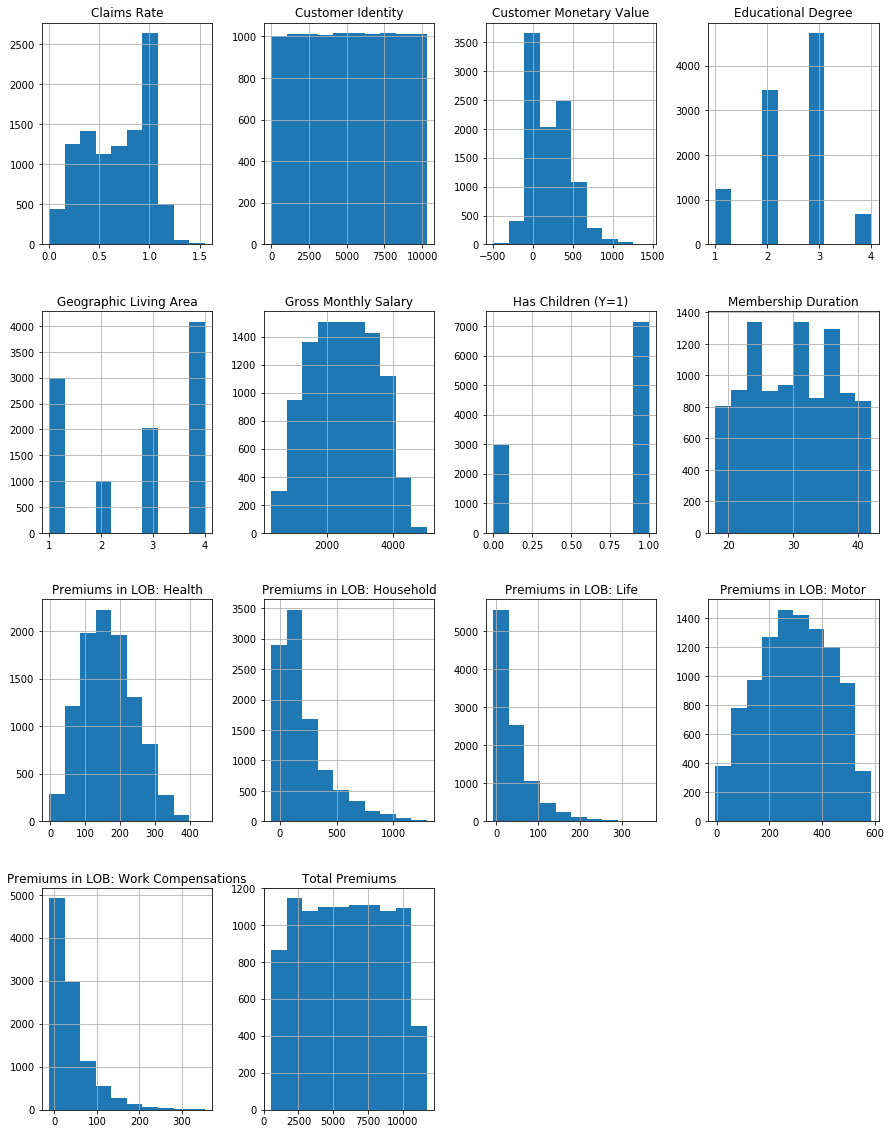

In [48]:
# Plot the histograms for all variables
pd.DataFrame.hist(df,figsize = (15,20))

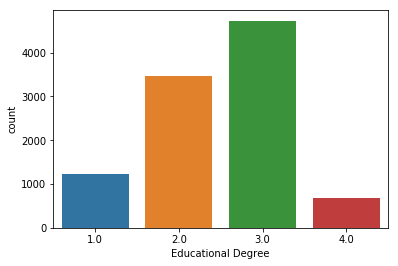

In [49]:
# Plot distribution of Educational Degree
sns.countplot(df_Engage['Educational Degree'])

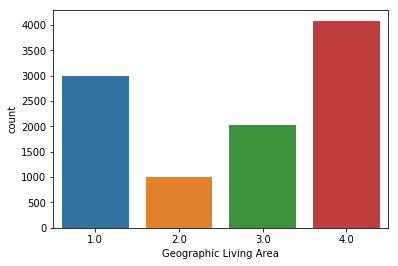

In [50]:
# Plot distribution of Geographic Living Area
sns.countplot(df_Engage['Geographic Living Area'])

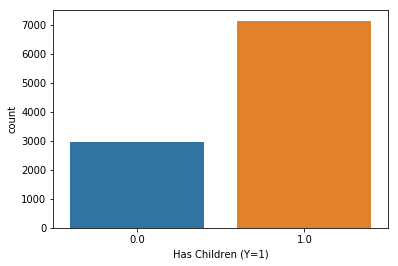

In [51]:
# Plot distribution of Has Children
sns.countplot(df_Engage['Has Children (Y=1)'])

Gross Monthly Salary


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


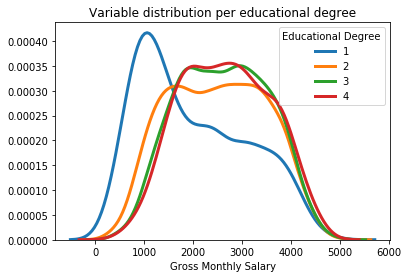

Premiums in LOB: Motor


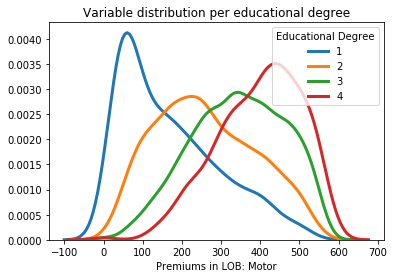

Premiums in LOB: Life


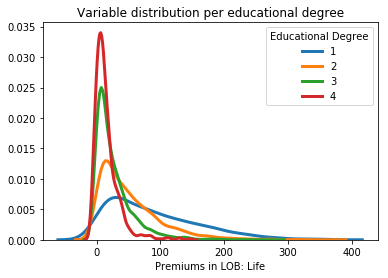

Premiums in LOB: Health


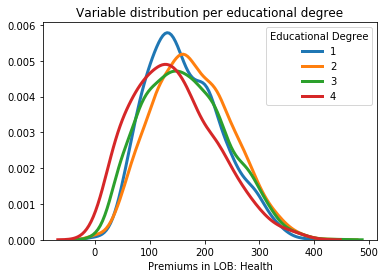

Premiums in LOB: Work Compensations


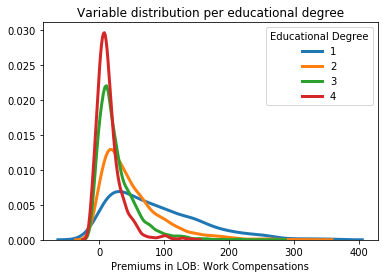

Premiums in LOB: Household


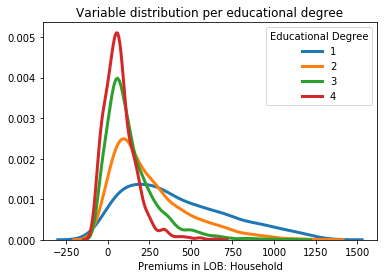

Membership Duration


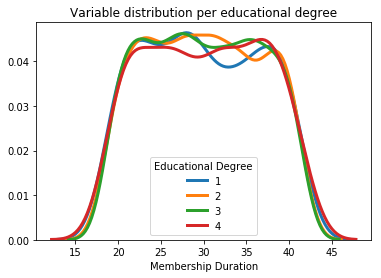

Customer Monetary Value


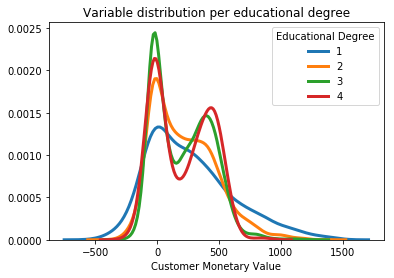

Total Premiums


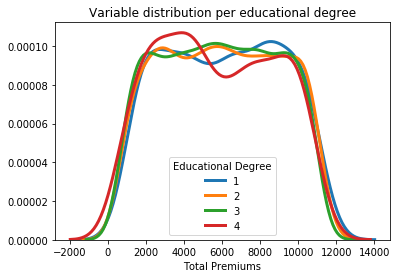

In [52]:
# Plot relationship between Educational Degree and other variables
categories = [1,2,3,4]

# Iterate through the educational degrees
for i in ['Gross Monthly Salary','Premiums in LOB: Motor','Premiums in LOB: Life','Premiums in LOB: Health','Premiums in LOB: Work Compensations','Premiums in LOB: Household','Membership Duration','Customer Monetary Value','Total Premiums']:
    print(i)
    for cat in categories:
        subset = df[df['Educational Degree'] == cat]

        # Draw the density plot
        sns.distplot(subset[i], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = cat)

    # Plot formatting
    plt.legend(prop={'size': 10}, title = 'Educational Degree')
    plt.title('Variable distribution per educational degree')
    plt.xlabel(i)
    plt.show()
    plt.clf()

Gross Monthly Salary


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


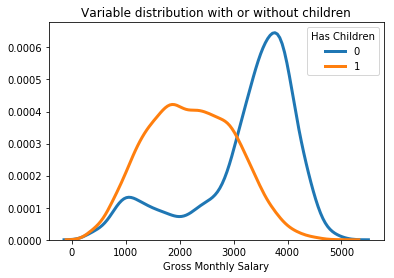

Premiums in LOB: Motor


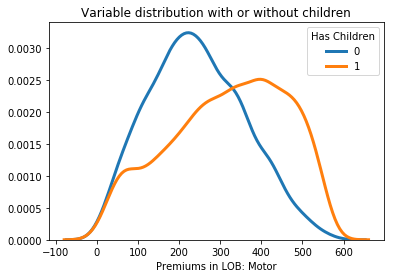

Premiums in LOB: Life


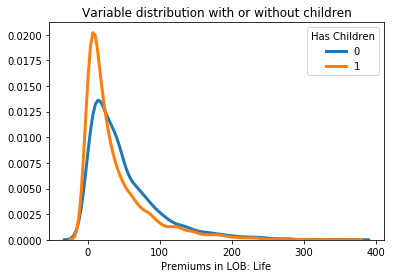

Premiums in LOB: Health


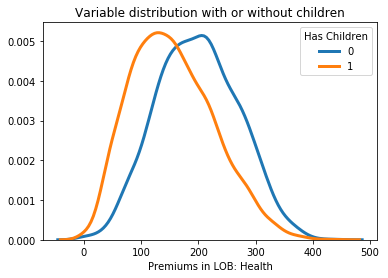

Premiums in LOB: Work Compensations


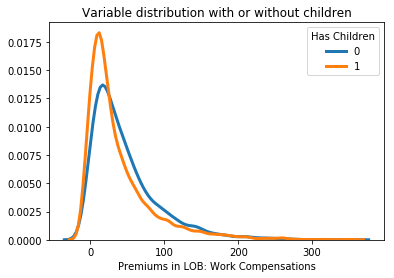

Premiums in LOB: Household


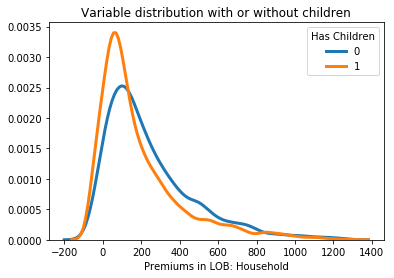

Membership Duration


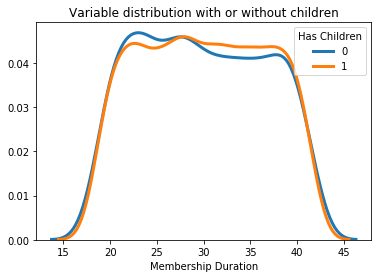

Customer Monetary Value


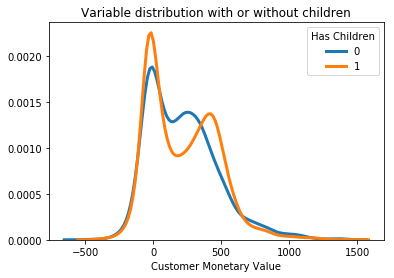

Total Premiums


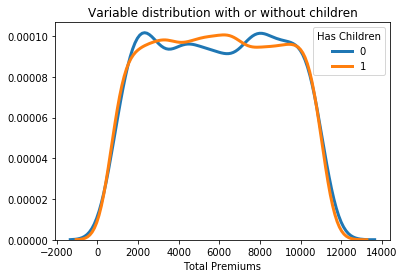

In [53]:
# Plot relationship between Has Children and other variables
categories = [0,1]

# Iterate through the educational degrees
for i in ['Gross Monthly Salary','Premiums in LOB: Motor','Premiums in LOB: Life','Premiums in LOB: Health','Premiums in LOB: Work Compensations','Premiums in LOB: Household','Membership Duration','Customer Monetary Value','Total Premiums']:
    print(i)
    for cat in categories:
        subset = df[df['Has Children (Y=1)'] == cat]

        # Draw the density plot
        sns.distplot(subset[i], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = cat)

    # Plot formatting
    plt.legend(prop={'size': 10}, title = 'Has Children')
    plt.title('Variable distribution with or without children')
    plt.xlabel(i)
    plt.show()
    plt.clf()

Gross Monthly Salary


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


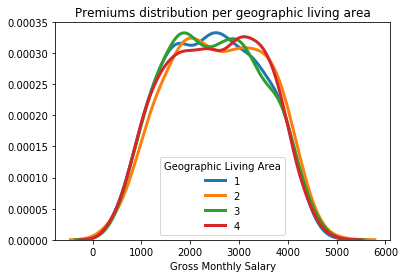

Premiums in LOB: Motor


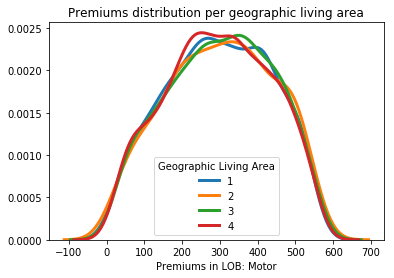

Premiums in LOB: Life


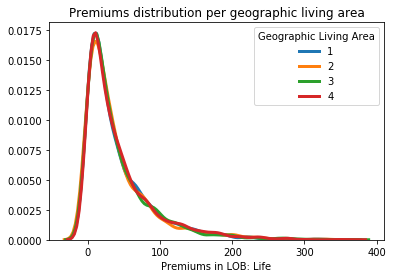

Premiums in LOB: Health


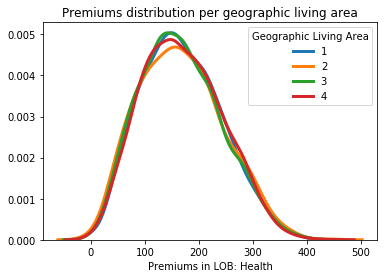

Premiums in LOB: Work Compensations


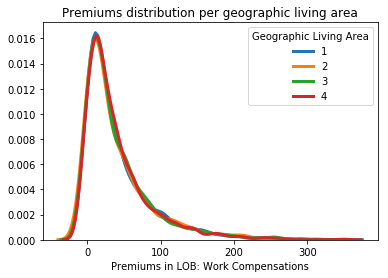

Premiums in LOB: Household


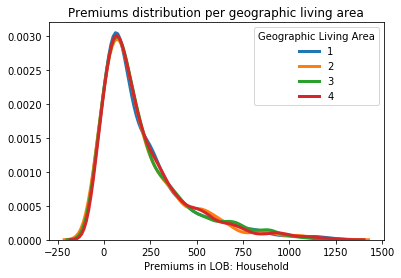

Membership Duration


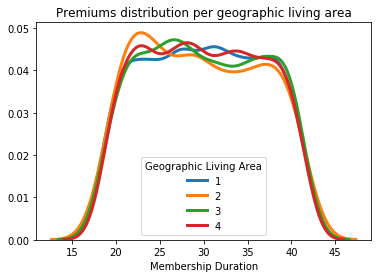

Customer Monetary Value


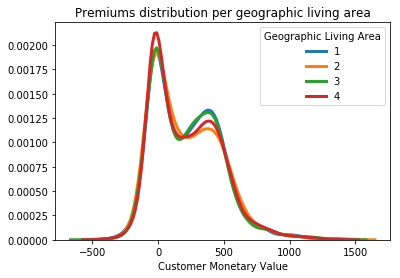

Total Premiums


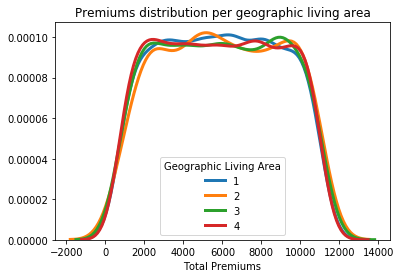

In [54]:
# Plot relationship between Geographic Living Area and other variables
categories = [1,2,3,4]

# Iterate through the educational degrees
for i in ['Gross Monthly Salary','Premiums in LOB: Motor','Premiums in LOB: Life','Premiums in LOB: Health','Premiums in LOB: Work Compensations','Premiums in LOB: Household','Membership Duration','Customer Monetary Value','Total Premiums']:
    print(i)
    for cat in categories:
        subset = df[df['Geographic Living Area'] == cat]

        # Draw the density plot
        sns.distplot(subset[i], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = cat)

    # Plot formatting
    plt.legend(prop={'size': 10}, title = 'Geographic Living Area')
    plt.title('Premiums distribution per geographic living area')
    plt.xlabel(i)
    plt.show()
    plt.clf()

In [55]:
df.columns

Index(['Customer Identity', 'Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations',
       'Educational Degree', 'Gross Monthly Salary', 'Geographic Living Area',
       'Has Children (Y=1)', 'Customer Monetary Value', 'Claims Rate',
       'Membership Duration', 'Total Premiums'],
      dtype='object')

In [56]:
df_Engage.head()

,Customer Identity,Membership Duration,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Total Premiums
0,1,31.0,2.0,2177.0,1.0,1.0,380.97,0.39,666.56
1,2,35.0,2.0,677.0,4.0,1.0,-131.13,1.12,912.96
2,3,25.0,1.0,2277.0,3.0,0.0,504.67,0.28,743.60
3,4,26.0,3.0,1099.0,4.0,1.0,-16.99,0.99,604.68
4,5,30.0,3.0,1763.0,4.0,1.0,35.23,0.90,634.24


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


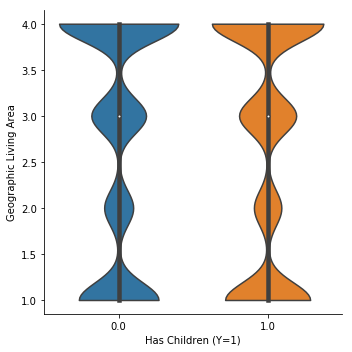

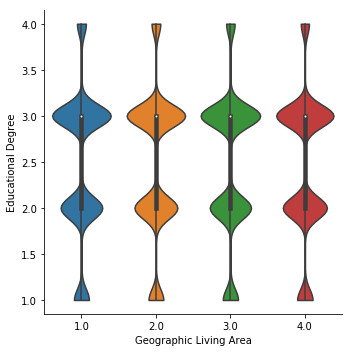

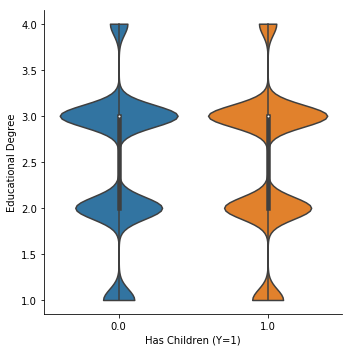

In [57]:
# Violin plots for the Categorical variables
sns.catplot(x="Has Children (Y=1)", y="Geographic Living Area",
            kind="violin", bw=.15, cut=0,
            data=df_Engage)
plt.show()
plt.clf()

sns.catplot(x="Geographic Living Area", y="Educational Degree",
            kind="violin", bw=.15, cut=0,
            data=df_Engage)
plt.show()
plt.clf()

sns.catplot(x="Has Children (Y=1)", y="Educational Degree",
            kind="violin", bw=.15, cut=0,
            data=df_Engage)
plt.show()
plt.clf()

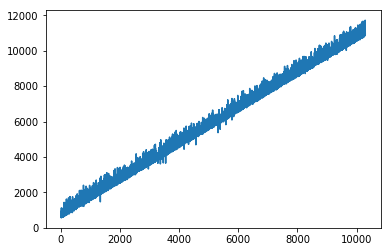

In [58]:
# Customer Identities seem to be given based on a customer's total spend in Premiums
plt.plot(df_Engage['Customer Identity'], df_Engage['Total Premiums'])

### TEST Approach: One-hot Encoding

In [59]:
# # Educational Degree

# df_education_encoded = pd.get_dummies(df_Merge_clean['Educational Degree'], prefix = 'Degree')
# df_education_encoded.head()

# df_Merge_clean = pd.concat([df_Merge_clean, df_education_encoded], axis=1, ignore_index=False,verify_integrity=False)
# df_Merge_clean = df_Merge_clean.drop(['Educational Degree'], axis=1)

# df_Merge_clean.head()

# # Geographic Living Area

# df_education_encoded = pd.get_dummies(df_Merge_clean['Geographic Living Area'], prefix = 'Living_Area')
# df_education_encoded.head()

# df_Merge_clean = pd.concat([df_Merge_clean, df_education_encoded], axis=1, ignore_index=False,verify_integrity=False)
# df_Merge_clean = df_Merge_clean.drop(['Geographic Living Area'], axis=1)

# df_Merge_clean.head()


# # After data cleaning, we can now split the dataset in order to get two different clusterings based on demographics and behaviour
# df_Merge_clean.columns


# df_LOB = df_Merge_clean[['Customer Identity', 'Premiums in LOB: Motor',
#        'Premiums in LOB: Household', 'Premiums in LOB: Health',
#        'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

# df_Engage = df_Merge_clean[['Customer Identity', 'Membership Duration', 'Gross Monthly Salary', 'Has Children (Y=1)',
#        'Customer Monetary Value', 'Claims Rate', 'Degree_1.0', 'Degree_2.0',
#        'Degree_3.0', 'Degree_4.0','Living_Area_1.0', 'Living_Area_2.0', 'Living_Area_3.0',
#        'Living_Area_4.0']]

### TEST Approach: Binning
  

In [60]:
# test_bin = df_Merge_clean.copy()
# test_bin['Gross Monthly Salary'] = pd.cut(k_proto_modes_bin['Gross Monthly Salary'], bins = list(range(300, 55300, 1000)), labels = np.arange(1300, 55300, 1000))

### TEST Approach: KPrototypes on full Data Set

In [61]:
# df_prototypes_all = df_Merge_clean[["Premiums in LOB: Motor", "Premiums in LOB: Household", "Premiums in LOB: Health", "Premiums in LOB: Life", "Premiums in LOB: Work Compensations", "Educational Degree", "Has Children (Y=1)","Gross Monthly Salary", "Claims Rate"]]
# from kmodes.kprototypes import KPrototypes
# test1=KPrototypes(n_clusters=4, init='Huang')
# cluster=test1.fit_predict(df_prototypes_all,categorical =[5,6])

# Engage Clustering

### Variable choice

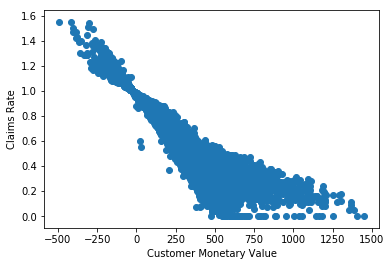

In [62]:
# Very strong correlation between claims rate and CMV
plt.scatter(df['Customer Monetary Value'],df['Claims Rate'])
plt.xlabel("Customer Monetary Value")
plt.ylabel("Claims Rate")

In [63]:
# Set up data frame
temp_df = df_Engage

# Normalize
engage_scaler = StandardScaler()

temp_df[['Gross Monthly Salary','Claims Rate', 'Total Premiums','Customer Monetary Value']] = engage_scaler.fit_transform(temp_df[['Gross Monthly Salary','Claims Rate','Total Premiums','Customer Monetary Value']])


# PCA

x = df_Engage[['Gross Monthly Salary','Claims Rate','Total Premiums']]

pca = PCA(n_components= 3)

pca.fit(x)
print(abs( pca.components_ ))
print(pca.explained_variance_ratio_)


C:\Users\jojo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\jojo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


[[0.6780644  0.18045447 0.71250604]
 [0.30559643 0.95084712 0.05000582]
 [0.66846054 0.25164647 0.69988182]]
[0.34358984 0.33370859 0.32270157]


In [64]:
# Observe data frame
df_Engage.head()

,Customer Identity,Membership Duration,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Total Premiums
0,1,31.0,2.0,-0.330247,1.0,1.0,0.645176,-0.917292,-1.758037
1,2,35.0,2.0,-1.856384,4.0,1.0,-1.373736,1.383127,-1.675333
2,3,25.0,1.0,-0.228505,3.0,0.0,1.132854,-1.263930,-1.732179
3,4,26.0,3.0,-1.427031,4.0,1.0,-0.923748,0.973464,-1.778807
4,5,30.0,3.0,-0.751461,4.0,1.0,-0.717875,0.689850,-1.768886


### Main approach: KPrototypes on Engage

In [65]:
# Set up data frame
temp_df = df_Engage.copy()

In [66]:
# Dictionary to replace variables
children_dict = {1:'Has Children', 0:'No Children'}
education_dict = {1:'Low Education',2:'Low Education',3:'High Education',4:'High Education'}
temp_df = temp_df.replace({'Has Children (Y=1)':children_dict,'Educational Degree':education_dict})

In [67]:
# Normalize
engage_scaler = StandardScaler()

temp_df[['Gross Monthly Salary','Claims Rate','Total Premiums']] = engage_scaler.fit_transform(temp_df[['Gross Monthly Salary','Claims Rate','Total Premiums']])

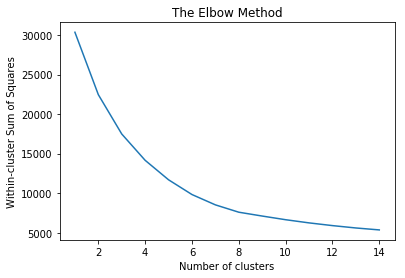

In [68]:
# Estimate appropriate number of clusters through the Elbow Method

x = temp_df[['Gross Monthly Salary','Claims Rate','Total Premiums']]

wcss=[]

for i in range(1,15):
  kmeans = KMeans(i)
  kmeans.fit(x)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)
  
number_cluster = range(1,15)
plt.plot(number_cluster,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

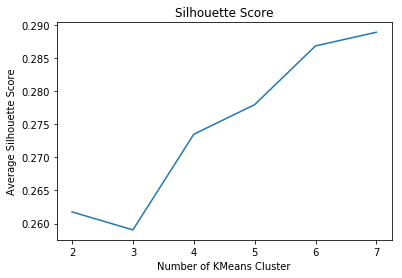

In [69]:
# Use silhouette score to determine quality of clusters
scores = []

# Loop through number of clusters
for n_cluster in  [2,3,4,5,6,7]:
    # Kmeans for each of the n_cluster
    kmeans = KMeans(n_clusters=n_cluster, 
                random_state=0,
                n_init = 5,
                max_iter = 200).fit(x)
    
    labels = kmeans.labels_
    
    # calculate silhouette score for each number of clusters
    score = metrics.silhouette_score(x, labels, metric='euclidean')
    scores.append([n_cluster,score])
#     print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_cluster, score))

scores = pd.DataFrame(scores)
scores.columns = ['n_cluster','score']
plt.plot(scores['n_cluster'],scores['score'])

plt.title('Silhouette Score')
plt.ylabel('Average Silhouette Score')
plt.xlabel('Number of KMeans Cluster')
plt.show()

In [70]:
# KPrototypes

df_kproto = temp_df[['Has Children (Y=1)','Educational Degree','Gross Monthly Salary','Claims Rate','Total Premiums']]

np.random.seed(0)

centroids_k_pro = []
cost_kproto = []

for no_clusters in range (4,5):
    
    ar_kproto = df_kproto.as_matrix()
    
    kproto = KPrototypes(n_clusters = no_clusters, init='Huang')
    
    clusters = kproto.fit_predict(ar_kproto, categorical=[0,1])
    
    centroids_k_pro.append(kproto.cluster_centroids_)
    
    temp_df["Cluster"] = clusters
    
    engage_size = temp_df.groupby(['Cluster']).size()

    
    
    # Observe engage cluster centroids
    engage_centroids_con = pd.DataFrame(engage_scaler.inverse_transform(kproto.cluster_centroids_[0]))
    engage_centroids_cat = pd.DataFrame(kproto.cluster_centroids_[1].tolist())
    engage_centroids = pd.concat([engage_centroids_con, engage_centroids_cat],axis=1)
    engage_centroids.columns = ['Gross Monthly Salary','Claims Rate','Total Premiums','Has Children','Educational Degree']
    engage_centroids['Cluster Size'] = temp_df.groupby(['Cluster']).size()
   
    
engage_centroids
#print("kproto-cost_: ",kproto.cost_)
#print("kproto.n_iter_: ",kproto.n_iter_, "\n")
#cost_kproto.append(kproto.cost_)


C:\Users\jojo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


,Gross Monthly Salary,Claims Rate,Total Premiums,Has Children,Educational Degree,Cluster Size
0,1.168658,0.355458,0.077263,No Children,High Education,2684
1,-0.558378,0.689905,-0.884765,Has Children,Low Education,2283
2,-0.714590,0.376628,0.993988,Has Children,Low Education,2384
3,-0.057258,-1.239415,-0.201490,Has Children,High Education,2765


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


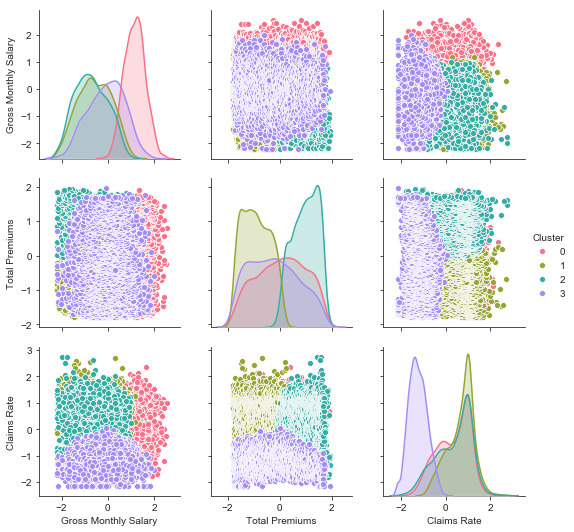

In [71]:
# Observe variable distribution per cluster
sns.set_style("ticks") 
sns.pairplot(data=temp_df,hue='Cluster',vars=['Gross Monthly Salary','Total Premiums','Claims Rate'],diag_kind="kde",kind="scatter",palette="husl") 
plt.show() 

In [72]:
# Set cluster labels to main data frame
df['Engage Cluster'] = temp_df['Cluster']

### TEST Approach: separate clustering of continuous and categorical variables

In [73]:
# # Plot continuous variables
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_Engage['Gross Monthly Salary'], df_Engage['Claims Rate'], df_Engage['Membership Duration'])

# ax.set_xlabel('Gross Monthly Salary')
# ax.set_ylabel('Claims Rate')
# ax.set_zlabel('Membership Duration')

In [74]:
# # Set up data frame
# temp_df = df_Engage

In [75]:
# # Data normalization
# engage_scaler= preprocessing.MinMaxScaler()

# # Normalize data
# temp_df[['Customer Monetary Value','Claims Rate','Total Premiums','Gross Monthly Salary']] = engage_scaler.fit_transform(temp_df[['Customer Monetary Value','Claims Rate','Total Premiums','Gross Monthly Salary']])

### Continuous clustering

In [76]:
# #### K MEANS
# # Set data 
# x = temp_df[['Total Premiums','Claims Rate','Gross Monthly Salary']]

# ## Elbow Method

# wcss=[]

# for i in range(1,15):
#   kmeans = KMeans(i)
#   kmeans.fit(x)
#   wcss_iter = kmeans.inertia_
#   wcss.append(wcss_iter)
  
# number_cluster = range(1,15)
# plt.plot(number_cluster,wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Within-cluster Sum of Squares')


# ### KMeans
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, 
#                 random_state=0,
#                 n_init = 5,
#                 max_iter = 200).fit(x)



# kmeans.inertia_

# kmeans.labels_

# kmeans.cluster_centers_

# #Check the clusters
# kmeans_clusters = pd.DataFrame(kmeans.cluster_centers_)

# # engage_scaler.inverse_transform(X = kmeans_clusters)

# temp_df['kmeans_label'] = kmeans.labels_

# ## Plot KMEANS 3D

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_Engage['Total Premiums'], df_Engage['Claims Rate'], df_Engage['Membership Duration'],c = temp_df['kmeans_label'])

# ax.set_xlabel('Gross Monthly Salary')
# ax.set_ylabel('Claims Rate')
# ax.set_zlabel('Membership Duration')


### Categorical Clustering (KModes)

In [77]:
# # KModes
# children_dict = {1:'Has Children', 0:'No Children'}
# education_dict = {1:'Basic',2:'High School',3:'Bsc/Msc',4:'PhD'}
# temp_df = temp_df.replace({'Has Children (Y=1)':children_dict,'Educational Degree':education_dict})

In [78]:
# # KModes Clustering
# x = temp_df[['Has Children (Y=1)','Educational Degree','Geographic Living Area']]
# km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
# clusters = km.fit_predict(x)
# print(km.cluster_centroids_)

# temp_df['Kmodes_labels'] = clusters

In [79]:
# # Check cluster sizes
# temp_df.groupby(['Kmodes_labels']).size()

In [80]:
# # Plot clusters
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_Engage['Geographic Living Area'],df_Engage['Educational Degree'],df_Engage['Has Children (Y=1)'],c = temp_df['Kmodes_labels'])

# ax.set_xlabel('Geographic Living Area')
# ax.set_ylabel('Educational Degree')
# ax.set_zlabel('Has Children (Y=1)')

# LOB Clustering

In [81]:
# Observe data frame
df_LOB.head()

,Customer Identity,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations
0,1,375.85,79.45,146.36,47.01,16.89
1,2,77.46,416.20,116.69,194.48,106.13
2,3,206.15,224.50,124.58,86.35,99.02
3,4,182.48,43.35,311.17,35.34,28.34
4,5,338.62,47.80,182.59,18.78,41.45


In [82]:
# Create data frame for clustering
LOB_cluster = df_LOB.copy()

#### Normalize

In [83]:
# Normalize
lob_scaler = MinMaxScaler()

LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]= lob_scaler.fit_transform(LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']])

#### PCA's for plotting

[[0.76958948 0.38784596 0.32940307 0.27408118 0.27144183]
 [0.07403127 0.48124394 0.80115139 0.24724775 0.24484413]
 [0.1232099  0.73566719 0.17418954 0.46937849 0.43926637]]
[0.64344676 0.19249821 0.08972125]


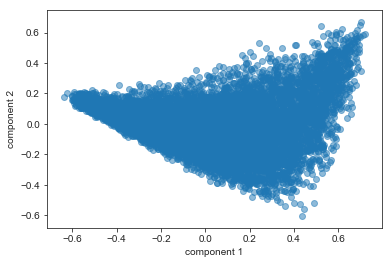

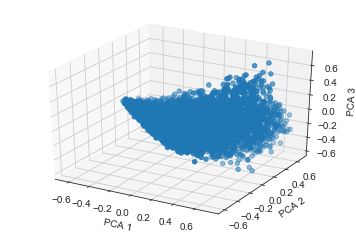

In [84]:
# PCA

x = LOB_cluster.drop(columns = 'Customer Identity')

pca = PCA(n_components= 3)

pca.fit(x)
print(abs( pca.components_ ))
print(pca.explained_variance_ratio_)

principalComponents = pca.fit_transform(x)

# to revert:
#pca.inverse_transform(principalComponents)

# Plot two of the principal components
plt.scatter(principalComponents[:, 0], principalComponents[:,1],
            alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2');

pca.inverse_transform(principalComponents)

principalComponents = pd.DataFrame(principalComponents)
principalComponents.columns = ['pca_1','pca_2','pca_3']

#Plot principal components in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalComponents['pca_1'],principalComponents['pca_2'],principalComponents['pca_3'])

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')


In [85]:
# Define data frame for plotting
plot = principalComponents

### TEST Approach: KMeans on PCA's

In [86]:
# #### K MEANS

# ## Elbow Method

# x = principalComponents

# wcss=[]

# for i in range(1,15):
#   kmeans = KMeans(i)
#   kmeans.fit(x)
#   wcss_iter = kmeans.inertia_
#   wcss.append(wcss_iter)
  
# number_cluster = range(1,15)
# plt.plot(number_cluster,wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Within-cluster Sum of Squares')


# ### KMEANS
# x = pd.DataFrame(x)
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, 
#                 random_state=0,
#                 n_init = 5,
#                 max_iter = 200).fit(x)



# kmeans.inertia_

# kmeans.labels_

# kmeans.cluster_centers_

# #Check the clusters
# kmeans_clusters = pd.DataFrame(kmeans.cluster_centers_)

# #lob_scaler has the fit parameters
# # lob_scaler.inverse_transform(X = kmeans_clusters)

# plot['kmeans_label'] = kmeans.labels_

# ## Plot KMEANS 3D

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = plot['kmeans_label'])

# ax.set_xlabel('PCA 1')
# ax.set_ylabel('PCA 2')
# ax.set_zlabel('PCA 3')

In [87]:
# # Show cluster centers
# lob_scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))

## KMeans

In [88]:
# Define data frame
x = LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

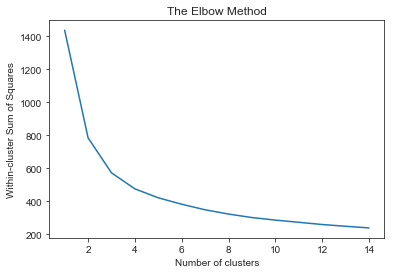

In [89]:
# Elbow Method to find optimum number of clusters

wcss=[]

for i in range(1,15):
  kmeans = KMeans(i)
  kmeans.fit(x)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)
  
number_cluster = range(1,15)
plt.plot(number_cluster,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

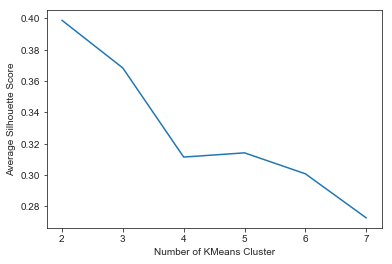

In [90]:
# Use silhouette score to determine quality of clusters
scores = []

# Loop through number of clusters
for n_cluster in  [2,3,4,5,6,7]:
    # Kmeans for each of the n_cluster
    kmeans = KMeans(n_clusters=n_cluster, 
                random_state=0,
                n_init = 5,
                max_iter = 200).fit(x)
    
    labels = kmeans.labels_
    
    # calculate silhouette score for each number of clusters
    score = metrics.silhouette_score(x, labels, metric='euclidean')
    scores.append([n_cluster,score])
#     print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_cluster, score))

scores = pd.DataFrame(scores)
scores.columns = ['n_cluster','score']
plt.plot(scores['n_cluster'],scores['score'])

plt.ylabel('Average Silhouette Score')
plt.xlabel('Number of KMeans Cluster')
plt.show()
    

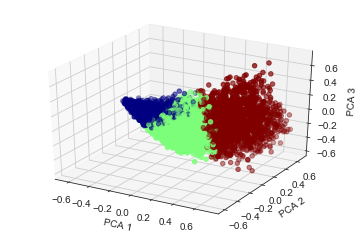

,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Cluster Size
0,433.718405,74.089866,108.908400,15.357220,14.730173,4099
1,243.155289,181.983594,227.318086,40.368385,40.197737,4156
2,115.299984,540.916085,164.794506,101.143002,98.455209,1861


In [91]:
### KMEANS
kmeans = KMeans(n_clusters=3, 
                random_state=0,
                n_init = 5,
                max_iter = 200).fit(x)



kmeans.inertia_

labels = kmeans.labels_

kmeans.cluster_centers_

#Check the clusters
kmeans_clusters = pd.DataFrame(kmeans.cluster_centers_)

LOB_cluster['kmeans_label'] = kmeans.labels_
plot['kmeans_label'] = kmeans.labels_
labels_minmax = kmeans.labels_

## Plot KMEANS 3D

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = plot['kmeans_label'], cmap=cm.jet)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

# Cluster sizes
# Print cluster centers
kmeans_centroids = pd.DataFrame(lob_scaler.inverse_transform(X = kmeans_clusters))
kmeans_centroids.columns = ['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']
kmeans_centroids['Cluster Size'] = LOB_cluster.groupby(['kmeans_label']).size()
kmeans_centroids


C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jojo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


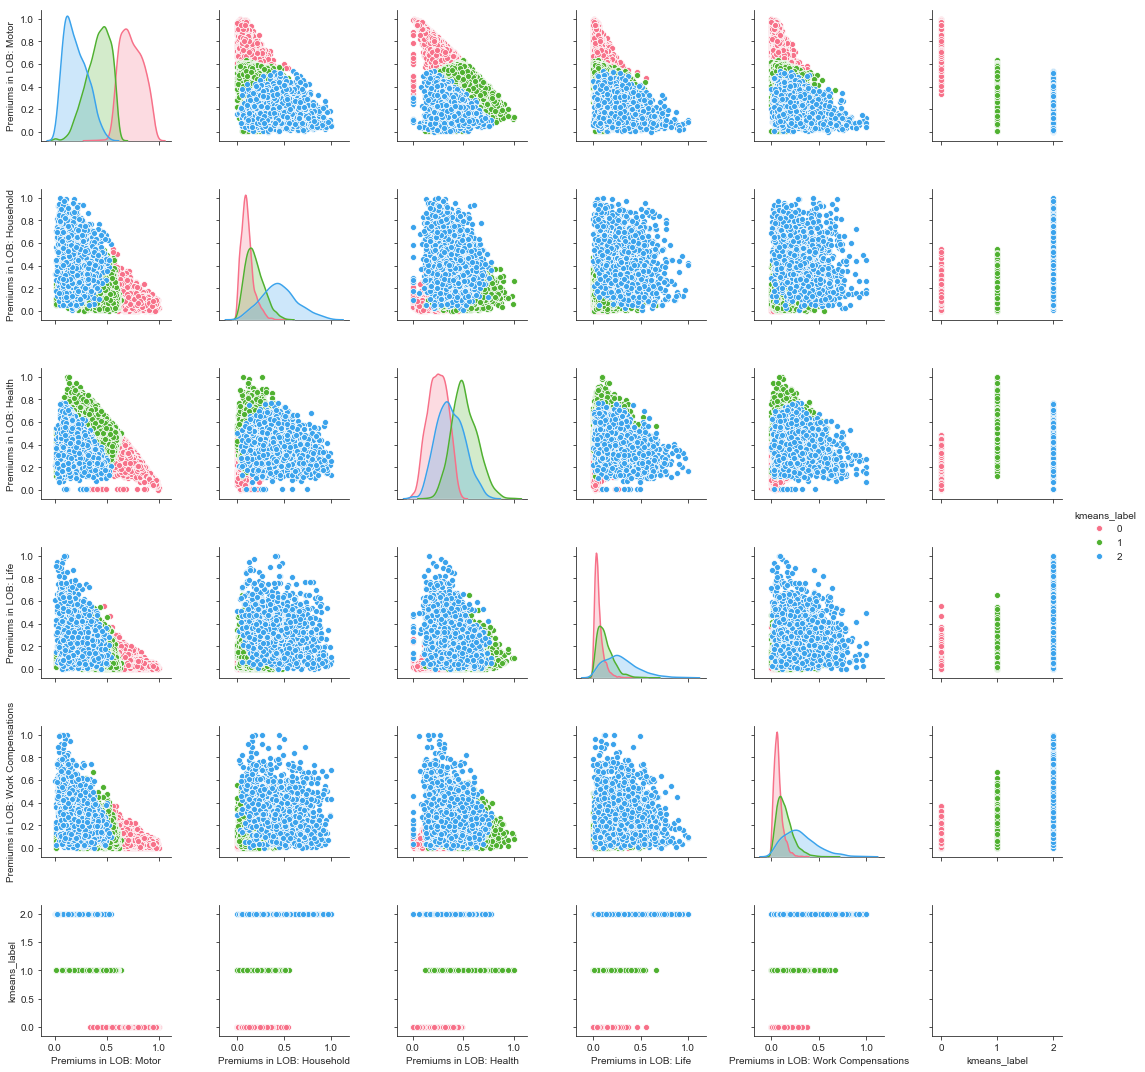

In [92]:
# Show distributions of all engage variables in a pairplot
sns.set_style("ticks") 
sns.pairplot(LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations','kmeans_label']],hue='kmeans_label',diag_kind="kde",kind="scatter",palette="husl") 
plt.show() 

In [93]:
#create an empty dataframe to store silhouete metric
silhouette_df = pd.DataFrame(columns=['Cluster Method', 'N° Clusters', 'silhouette score'])
calinski_harabaz_df= pd.DataFrame(columns=['Cluster Method', 'N° Clusters', 'calinski harabaz score'])

In [94]:
# Silhouette score
score = metrics.silhouette_score(x, labels, metric='euclidean')
print('Average silhouette score of KMeans: ',score)

Average silhouette score of KMeans:  0.36838949380024477


In [95]:
#calinski_harabaz score
score_kmean_calinski= metrics.calinski_harabaz_score(x, labels)  
print('Average calinski_harabaz score of KMeans: ',score_kmean_calinski)

Average calinski_harabaz score of KMeans:  7640.17103300005


In [96]:
#Append silhouette score in a dataframe
list=[["Kmean",3,score]]

silhouette_df = silhouette_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'silhouette score']),ignore_index=True)

#Append calinski_harabaz score in a dataframe
list=[["Kmean",3,score_kmean_calinski]]

calinski_harabaz_df = calinski_harabaz_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'calinski harabaz score']),ignore_index=True)


## Hierarchical Clustering

In [97]:
# Create data frame
x = LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

#### Dendogram

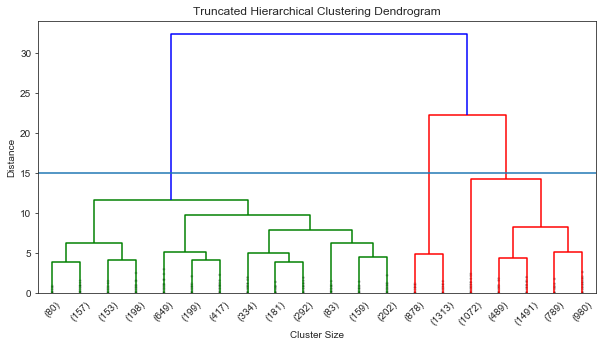

In [98]:
# Configure dendogram and plot
np.set_printoptions(precision=4,
                    threshold = 200,
                    suppress = True)

plt.figure(figsize=(10,5))

Z = linkage(x,
            method = 'ward')#method='single, complete

dendrogram(Z,
           #truncate_mode='none',
           truncate_mode='lastp',
           p=20,
           orientation = 'top',
           leaf_rotation=45.,
           leaf_font_size=10.,
           show_contracted=True,
           show_leaf_counts=True)

plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

#plt.axhline(y=50)
plt.axhline(y=15)

plt.show()

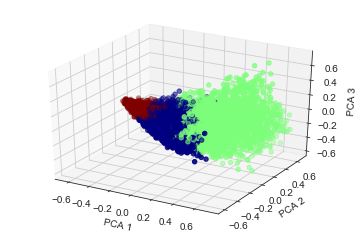

,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Cluster Size
0,307.302582,127.451151,195.947884,29.617600,29.351811,4821
1,150.127458,439.239046,185.243579,83.077445,80.773818,3104
2,481.743368,40.654518,81.237024,8.363441,8.430717,2191


In [99]:
## Hierarchical clustering
k=3

Hclustering = AgglomerativeClustering(n_clusters=k,
                                      affinity='euclidean',
                                      linkage='ward')


my_HC = Hclustering.fit(x)

labels = my_HC.labels_

LOB_cluster['hierarchical_label'] = my_HC.labels_ 
plot['hierarchical_label'] = my_HC.labels_
    
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = LOB_cluster['hierarchical_label'], cmap=cm.jet)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

# Hierarchical centroids
to_revert = LOB_cluster.groupby(['hierarchical_label'])['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations'].mean()    

hierarchical_centroids = pd.DataFrame(lob_scaler.inverse_transform(X=to_revert))
hierarchical_centroids.columns = ['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']
hierarchical_centroids['Cluster Size']=LOB_cluster.groupby(['hierarchical_label']).size()
hierarchical_centroids

C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jojo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


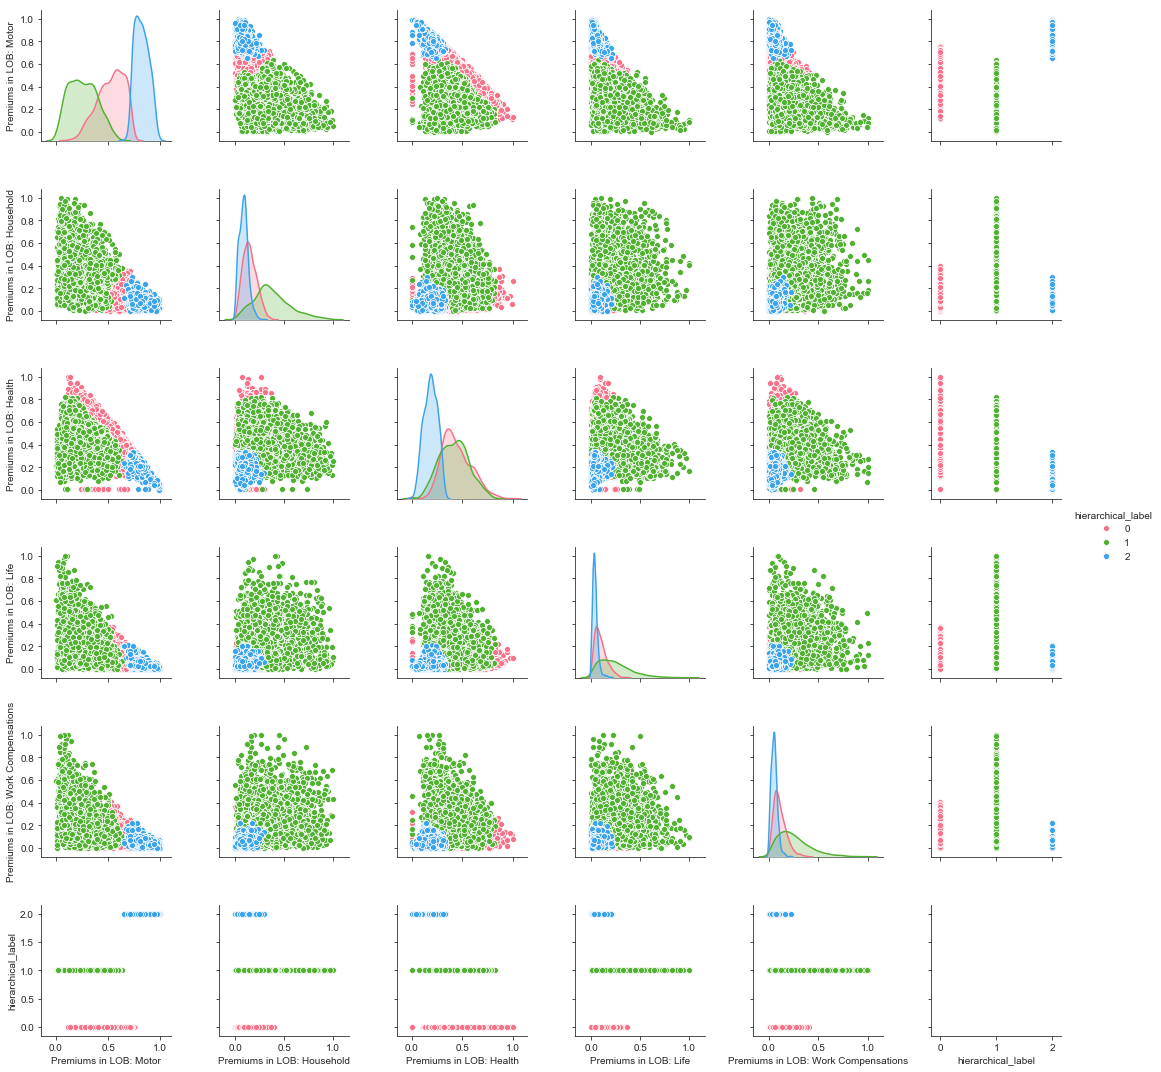

In [100]:
# Show distributions of all engage variables in a pairplot
sns.set_style("ticks") 
sns.pairplot(LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations','hierarchical_label']],hue='hierarchical_label',diag_kind="kde",kind="scatter",palette="husl") 
plt.show() 

In [101]:
# Silhouette score
score = metrics.silhouette_score(x, labels, metric='euclidean')
print('Average silhouette score of Hierarchical Clustering: ',score)

Average silhouette score of Hierarchical Clustering:  0.2737703735839273


In [102]:
#calinski_harabaz
score_hierarchical_calinski= metrics.calinski_harabaz_score(x, labels)  
print('Average calinski_harabaz score of Hierarchical Clustering: ',score_hierarchical_calinski)

Average calinski_harabaz score of Hierarchical Clustering:  5913.123452884313


In [103]:
#Append silhouette score in a dataframe
list=[["Hierarchical",k,score]]

silhouette_df = silhouette_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'silhouette score']),ignore_index=True)

#Append calinski_harabaz score in a dataframe
list=[["Hierarchical",k,score_hierarchical_calinski]]

calinski_harabaz_df = calinski_harabaz_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'calinski harabaz score']),ignore_index=True)


## Expectation Maximization

In [104]:
# Create data frame
x = LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

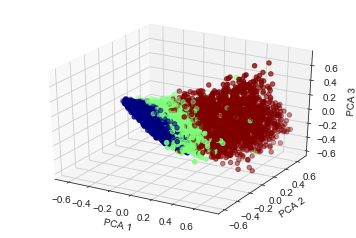

,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Cluster Size
0,404.251119,68.954154,142.869531,13.558184,13.763299,4787
1,265.705720,208.883283,194.881448,41.895334,40.365794,2789
2,144.306827,432.027173,183.019849,88.752638,86.901194,2540


In [105]:
# Expectation-Maximization

gmm = mixture.GaussianMixture(n_components=3,
                              covariance_type='full',
                              init_params='kmeans',
                              max_iter=1000,
                              n_init=10)

gmm.fit(x)
EM_labels_ = gmm.predict(x)
#Elbow
EM_score_ = gmm.score(x)
#Individual
EM_score_samp = gmm.score_samples(x)
#Individual
EM_pred_prob = gmm.predict_proba(x)

labels = EM_labels_
plot['EM_label'] = EM_labels_
LOB_cluster['EM_label']= EM_labels_

unique_clusters, counts_clusters = np.unique(EM_labels_, return_counts = True)

#Check the distribution
gmm.weights_ # this value is goint to be slightly different than the values for hard clustering (lable based) weights are based on soft clustering
gmm_means= gmm.means_

## 3D plot of EM
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = plot['EM_label'],cmap=cm.jet )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

# EM centroids
EM_centroids = pd.DataFrame(lob_scaler.inverse_transform(gmm.means_))
EM_centroids.columns = ['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']
EM_centroids['Cluster Size'] = LOB_cluster.groupby(['EM_label']).size()
EM_centroids

C:\Users\jojo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jojo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jojo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


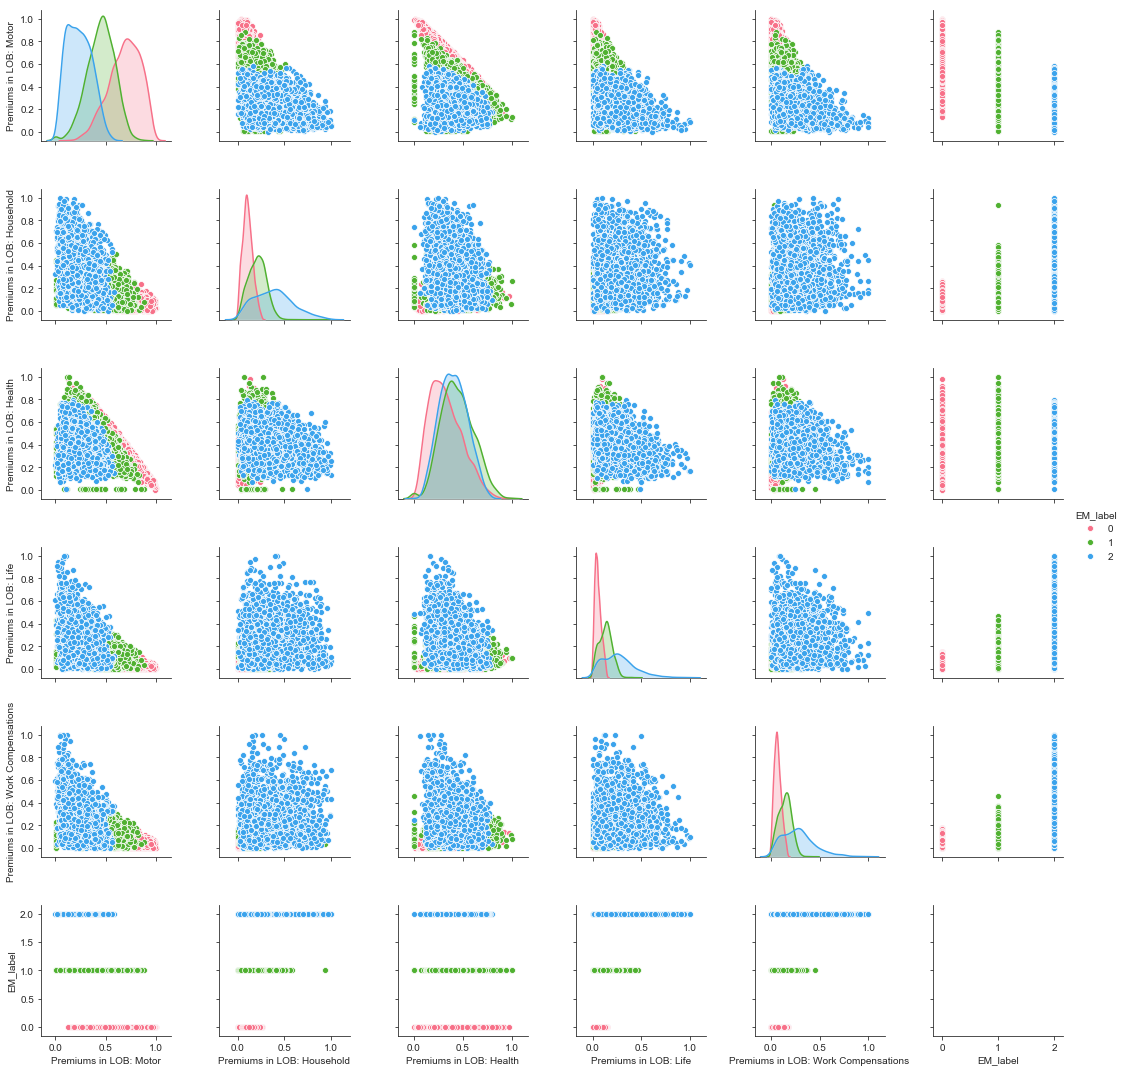

In [106]:
# Show distributions of all engage variables in a pairplot
sns.set_style("ticks") 
sns.pairplot(LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations','EM_label']],hue='EM_label',diag_kind="kde",kind="scatter",palette="husl") 
plt.show() 

In [107]:
# Silhouette score
score = metrics.silhouette_score(x, labels, metric='euclidean')
print('Average silhouette score of Expectation Maximization Clustering: ',score)

Average silhouette score of Expectation Maximization Clustering:  0.1880293599322584


In [108]:
#calinski_harabaz score
score_exp_max_calinski= metrics.calinski_harabaz_score(x, labels)  
print('Average calinski_harabaz score of Expectation Maximization Clustering: ',score_exp_max_calinski)

Average calinski_harabaz score of Expectation Maximization Clustering:  4234.089374470347


In [109]:
#Append silhouette score in a dataframe
list=[["Expectation Maximization",3,score]]

silhouette_df = silhouette_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'silhouette score']),ignore_index=True)

#Append calinski_harabaz score in a dataframe
list=[["Expectation Maximization",3,score_exp_max_calinski]]

calinski_harabaz_df = calinski_harabaz_df.append(pd.DataFrame(list, columns=['Cluster Method', 'N° Clusters', 'calinski harabaz score']),ignore_index=True)


## Mean Shift Clustering

In [110]:
# Create data frame
x = LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

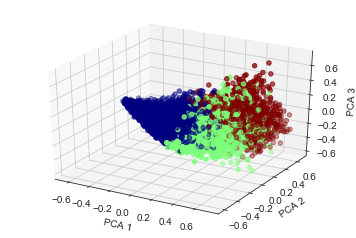

,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Cluster Size
0,3.999997e+02,88.210399,135.017519,18.252872,17.916263,7344
1,1.022325e-15,84.973077,139.419231,15.190769,10.993846,1892
2,6.290000e+01,303.400000,0.000000,128.690000,0.000000,880


In [111]:
# Estimate bandwidth
my_bandwidth = estimate_bandwidth(x,
                               quantile=0.17,
                               n_samples=1000)

# Mean shift

ms = MeanShift(bandwidth=my_bandwidth,
               #bandwidth=0.15,
               bin_seeding=True)

ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plot['MS_label'] = labels
LOB_cluster['MS_label'] = labels

## 3D plot of DBScan
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = plot['MS_label'],cmap=cm.jet )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

# Mean Shift centroids
MS_centroids = pd.DataFrame(lob_scaler.inverse_transform(X=cluster_centers))
MS_centroids.columns = ['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']
MS_centroids['Cluster Size'] = LOB_cluster.groupby(['MS_label']).size()
MS_centroids


## DBScan

In [112]:
# Create data frame
x = LOB_cluster[['Premiums in LOB: Motor',
       'Premiums in LOB: Household', 'Premiums in LOB: Health',
       'Premiums in LOB: Life', 'Premiums in LOB: Work Compensations']]

K=  25


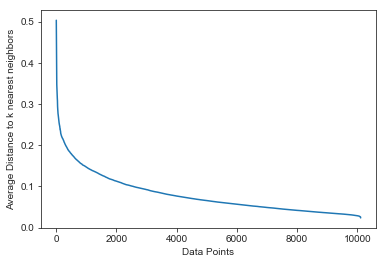

In [113]:
## Estimating radius via Nearest Neighbor graph
ns = 25
nbrs = NearestNeighbors(n_neighbors=ns).fit(x)
distances, indices = nbrs.kneighbors(x)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(distanceDec)
print('K= ',ns)

plt.ylabel('Average Distance to k nearest neighbors')
plt.xlabel('Data Points')
plt.show()



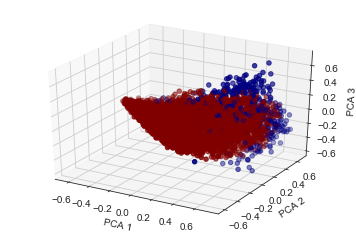

dbscan_label
-1     390
 0    9726
dtype: int64

In [114]:
## DBScan with the chosen variables
# working well for pca clustering: 0.06, 30 non-pca: 0.1
db = DBSCAN(eps=0.15,
            min_samples=25).fit(x)

labels = db.labels_

plot['dbscan_label'] = labels
LOB_cluster['dbscan_label'] = labels

## 3D plot of DBScan
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot['pca_1'], plot['pca_2'], plot['pca_3'], c = plot['dbscan_label'],cmap=cm.jet )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

# Cluster size
LOB_cluster.groupby(['dbscan_label']).size()

## Clustering Method Evaluation

In [115]:
#Table evaluation cluster method silhouette score LOB
silhouette_df

,Cluster Method,N° Clusters,silhouette score
0,Kmean,3,0.368389
1,Hierarchical,3,0.273770
2,Expectation Maximization,3,0.188029


In [116]:
#Table evaluation cluster methodcalinski_harabaz score LOB 
calinski_harabaz_df

,Cluster Method,N° Clusters,calinski harabaz score
0,Kmean,3,7640.171033
1,Hierarchical,3,5913.123453
2,Expectation Maximization,3,4234.089374


# Combine Engage and LOB Clusters

In [117]:
# Set LOB cluster labels
df['LOB Cluster'] = LOB_cluster['kmeans_label']

In [118]:
# Create new data frame in order not to loose information
df_join = df.copy()

In [119]:
# Set temporary names for each cluster for easier interpretation
lob_dict = {0:'Motor Fans',1:'Health first',2:'Homey, safe'}
engage_dict = {0:'Wealthy, childless',1:'Unprofitable lower class',2:'Lower class families',3:'Profitable families'}

In [120]:
# Replace cluster names in the data frame columns
df_join['LOB Cluster'] = df_join['LOB Cluster'].replace(lob_dict)
df_join['Engage Cluster'] = df_join['Engage Cluster'].replace(engage_dict)

In [121]:
# Join table with Engage and LOB clusters
join_clust = pd.DataFrame(np.column_stack((df_join['Engage Cluster'],df_join['LOB Cluster'])))
join_clust.columns =  ['Engage_cluster','LOB_cluster']

join_clust.head()

,Engage_cluster,LOB_cluster
0,Profitable families,Motor Fans
1,Unprofitable lower class,"Homey, safe"
2,Profitable families,"Homey, safe"
3,Unprofitable lower class,Health first
4,Unprofitable lower class,Health first


In [122]:
# Create crosstable
crosstab = pd.crosstab(join_clust.LOB_cluster,join_clust.Engage_cluster)
crosstab

Engage_cluster,Lower class families,Profitable families,Unprofitable lower class,"Wealthy, childless"
LOB_cluster,,,,
Health first,952,664,921,1619
"Homey, safe",670,399,484,308
Motor Fans,762,1702,878,757


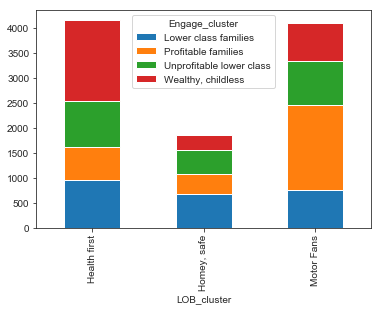

In [123]:
#Showing distribution of engage within lob clusters as stacked bars
crosstab.plot.bar(stacked=True)

In [124]:
# Observe lob cluster centroids
lob_centroids = kmeans_centroids
lob_centroids['Cluster Name'] = ['Motor Fans','Homey, safe','Health first']
lob_centroids

,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Cluster Size,Cluster Name
0,433.718405,74.089866,108.908400,15.357220,14.730173,4099,Motor Fans
1,243.155289,181.983594,227.318086,40.368385,40.197737,4156,"Homey, safe"
2,115.299984,540.916085,164.794506,101.143002,98.455209,1861,Health first


In [125]:
# Observe engage cluster centroids
engage_centroids['Est. Net Profit'] = engage_centroids['Total Premiums'] * (1-engage_centroids['Claims Rate'])
engage_centroids['Cluster Name'] = ['Wealthy, childless','Unprofitable lower class','Lower class families','Middle class families']
engage_centroids

,Gross Monthly Salary,Claims Rate,Total Premiums,Has Children,Educational Degree,Cluster Size,Est. Net Profit,Cluster Name
0,1.168658,0.355458,0.077263,No Children,High Education,2684,0.049799,"Wealthy, childless"
1,-0.558378,0.689905,-0.884765,Has Children,Low Education,2283,-0.274361,Unprofitable lower class
2,-0.714590,0.376628,0.993988,Has Children,Low Education,2384,0.619624,Lower class families
3,-0.057258,-1.239415,-0.201490,Has Children,High Education,2765,-0.451221,Middle class families


In [126]:
# Show mean values over all cluster combinations
df.groupby(['LOB Cluster','Engage Cluster']).mean()

Customer Identity  Premiums in LOB: Motor  \
LOB Cluster Engage Cluster                                              
0           0                     5611.900925              413.327094   
            1                     2647.506834              436.366185   
            2                     8223.853018              433.751798   
            3                     4731.135135              441.469882   
1           0                     5299.326127              238.285633   
            1                     2456.166124              236.224919   
            2                     8048.943277              240.173466   
            3                     4386.953313              269.311642   
2           0                     5356.129870              140.480714   
            1                     2391.148760              100.141116   
            2                     7963.982090              105.052806   
            3                     4206.506266              130.689148   

                            Premiums in LOB: Household  \
LOB Cluster Engage Cluster                               
0           0                                90.497424   
            1                                72.049260   
            2                                74.757283   
            3                                67.341539   
1           0                               180.342279   
            1                               175.475516   
            2                               178.260767   
            3                               201.584413   
2           0                               494.665097   
            1                               513.721281   
            2                               534.461493   
            3                               619.893108   

                            Premiums in LOB: Health  Premiums in LOB: Life  \
LOB Cluster Engage Cluster                                                   
0           0                            120.651532              18.408732   
            1                            106.892904              14.938929   
            2                            109.688097              14.957651   
            3                            104.358737              14.396704   
1           0                            234.394280              39.996504   
            1                            227.231053              44.193626   
            2                            230.265126              40.266513   
            3                            205.441657              35.932199   
2           0                            181.034545              83.537825   
            1                            163.977665             115.354112   
            2                            161.248343             108.469209   
            3                            159.686817              85.578070   

                            Premiums in LOB: Work Compensations  \
LOB Cluster Engage Cluster                                        
0           0                                         17.667768   
            1                                         14.257460   
            2                                         14.412874   
            3                                         13.810217   
1           0                                         38.466170   
            1                                         43.010619   
            2                                         42.243382   
            3                                         37.576114   
2           0                                         84.156136   
            1                                        104.534339   
            2                                        107.295612   
            3                                         87.368521   

                            Educational Degree  Gross Monthly Salary  \
LOB Cluster Engage Cluster                                             
0           0   

## Merging Clusters

In [127]:
# Create data frame
final_join_clust = join_clust.copy()

In [128]:
# Replace string values for easier replacement in the following
final_join_clust["Engage_cluster"].astype(str)
final_join_clust.replace(to_replace={"Profitable families":0,"Lower class families":1,"Unprofitable lower class":2,"Wealthy, childless":3},inplace=True)
final_join_clust["LOB_cluster"].astype(str)
final_join_clust.replace(to_replace={"Health first":0,"Homey, safe":1,"Motor Fans":2},inplace=True)

final_join_clust.head()

,Engage_cluster,LOB_cluster
0,0,2
1,2,1
2,0,1
3,2,0
4,2,0


In [129]:
# Give each combination of engage and lob cluster an index so we can group togeher easily by index
for eng in range(len(final_join_clust["Engage_cluster"].unique())):
    for lob in range(len(final_join_clust["LOB_cluster"].unique())):
        for index, row in final_join_clust.iterrows():
            if final_join_clust.at[index,'Engage_cluster'] == eng and final_join_clust.at[index,'LOB_cluster'] == lob:
                final_join_clust.at[index,'index'] = "{}{}".format(eng,lob)

In [130]:
# observe data frame
final_join_clust.head()

,Engage_cluster,LOB_cluster,index
0,0,2,02
1,2,1,21
2,0,1,01
3,2,0,20
4,2,0,20


In [131]:
# Join clusters together by resetting the indexes
final_join_clust["index"].astype(str)
final_join_clust.replace(to_replace={"31":"30","00":"10","01":"41","11":"41","02":"52","12":"52","32":"02"},inplace=True)

final_join_clust['Customer_segment'] = final_join_clust['index'].str[0:1]
final_join_clust['final_LOB_cluster'] = final_join_clust['index'].str[1:2]
final_join_clust['final_LOB_cluster'].astype(int)
final_join_clust['Customer_segment'].astype(int)
final_join_clust.head()

,Engage_cluster,LOB_cluster,index,Customer_segment,final_LOB_cluster
0,0,2,52,5,2
1,2,1,21,2,1
2,0,1,41,4,1
3,2,0,20,2,0
4,2,0,20,2,0


In [132]:
# Set temporary names for each cluster for easier interpretation
lob_dict1 = {"1":'Homey, safe',"0":'Health first',"2":'Motor Fans'}
engage_dict1 = {"5":'Middle-class families',"1":'Health-oriented families',"3":'Wealthy, health-focused',"2":'Unprofitable families',"0":"Wealthy Motor Fans","4":"Lower class families"}
final_join_clust['Customer_segment'] =final_join_clust['Customer_segment'].replace(to_replace=engage_dict1)
final_join_clust['final_LOB_cluster'] =final_join_clust['final_LOB_cluster'].replace(to_replace=lob_dict1)

In [133]:
# Look at the mean values of all variables for each cluster
df['Net Profit'] = df['Total Premiums'] * (1-df['Claims Rate'])
df['index'] = final_join_clust['index']
df['Cluster'] = final_join_clust['Customer_segment']
cluster_means = df.groupby(['Cluster']).mean()
cluster_means= cluster_means.round(2)
cluster_means

,Customer Identity,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Membership Duration,Total Premiums,Engage Cluster,LOB Cluster,Net Profit
Cluster,,,,,,,,,,,,,,,,,
Health-oriented families,6419.02,294.84,208.24,167.46,42.02,42.31,2.47,2510.20,2.72,0.70,218.34,0.68,30.17,7173.90,1.57,0.79,2282.21
Lower class families,6442.08,298.22,207.52,168.87,39.48,38.87,2.50,2492.64,2.75,0.71,204.49,0.70,29.66,7195.04,1.53,0.78,2139.24
Middle-class families,5699.76,297.21,202.71,168.01,41.67,41.01,2.48,2484.85,2.73,0.71,218.67,0.68,30.14,6450.35,1.55,0.77,2066.51
Unprofitable families,2470.30,295.85,203.66,168.36,40.92,40.69,2.48,2527.23,2.71,0.70,221.68,0.67,29.86,3219.79,1.42,0.77,1026.17
Wealthy Motor Fans,5522.36,303.18,204.83,164.94,39.94,37.68,2.50,2551.00,2.67,0.71,219.78,0.68,29.85,6272.92,1.51,0.77,2036.78
"Wealthy, health-focused",5209.38,295.73,201.88,168.21,42.70,40.68,2.47,2484.80,2.69,0.70,212.48,0.68,29.89,5958.58,1.51,0.79,1876.35


In [134]:
#Check cluster size
size = df.groupby(['Cluster']).size()
size

Cluster
Health-oriented families    1582
Lower class families        1048
Middle-class families       2434
Unprofitable families       2227
Wealthy Motor Fans           746
Wealthy, health-focused     1899
dtype: int64

In [136]:
# Create crosstable
crosstab1 = pd.crosstab(final_join_clust.final_LOB_cluster,final_join_clust.Customer_segment)
crosstab1

Customer_segment,Health-oriented families,Lower class families,Middle-class families,Unprofitable families,Wealthy Motor Fans,"Wealthy, health-focused"
final_LOB_cluster,,,,,,
Health first,1616,0,0,921,0,1927
"Homey, safe",0,1069,0,484,0,0
Motor Fans,0,0,2464,878,757,0


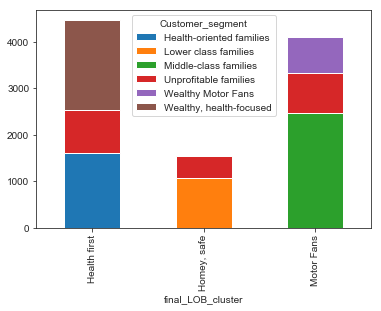

In [137]:
# Stacked view of combined clusters
crosstab1.plot.bar(stacked=True)